#

# Import all the libraries that we will need 

In [1]:
import copy
import csv
import dabest
import datetime
import fnmatch
import glob
from IPython.display import Image, display
import itertools
from itertools import groupby
import math
import matplotlib.cbook
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import numpy as np
from numpy.polynomial.polynomial import polyfit
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import re
import scipy
from scipy import stats
from scipy.ndimage import gaussian_filter as smooth
from scipy.signal import find_peaks
import statistics
import sys
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()

# Define data path.

In [2]:
###Set the notebook screen ratio for jupyter
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:85% !important; }</style>"))

#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/testDist3Days"#2TM/20210622"#root="/home/david/Desktop/DATARUN_ANALYSIS/test0727"#new/test1203"#DATARUN ANALYSIS/all distance" #all distances" #DATARUN ANALYSIS/test0820
    savePath="/home/david/Desktop/Save"
else: #mac: if platform.system()=='Darwin':
    root="/Users/tom/Downloads/DATATEST/20210211"#AET-2/test1203"#Desktop/DATARUN_ANALYSIS/test0826"#" #current : test0826
    savePath="/Users/tom/Desktop/Save"#os.path.join(root,"ALLRATS","Fig")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)#print("Notebook Path: ", notebookPath)
print("Save Path: ", savePath)   

Path to data is: /home/david/Desktop/testDist3Days1Rat
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save


# Define functions

In [3]:
###------------------------------------------------------------------------------------------------------------------
### Utility/low_level computation functions()
###------------------------------------------------------------------------------------------------------------------

# conversion
def inch2cm(value): return value / 2.54
def cm2inch(value): return value * 2.54

#new px to cm conversion. To correct camera lens distorsion (pixels in the center of the treadmill are more precise than the ones located at the extremities), I directly applied a filter in LabView, and conversion should be uniform now, 11 px is equal to 1 cm at every point of the treadmill.
def datapx2cm(list):
    array = []
    for pos in list:
        if pos == 0:
            array.append(pos)
        elif pos > 0 and pos < 1300:
            array.append(pos/11)
        else: 
            array.append(pos)
            print("might have error in position", pos)
    return array         

#function to split lists --> used to split the raw X position array into smaller arrays (runs and stays). Later in the code we modify the array and change some values to 0, which will be used as cutting points.
def split_a_list_at_zeros(List):
    return [list(g) for k, g in groupby(List, key=lambda x:x!=0) if k]

#function to open and read from the .position files using pandas, specify the path of the file to open, the column that you want to extract from, and the extension of the file
def read_csv_pandas(path, Col=None, header=None):
    #verify that the file exists
    if not os.path.exists(path):
        print("No file %s"%path)
        return []
    try: #open the file
        csvData=pd.read_csv(path, header=header, delim_whitespace=True, low_memory=False)
    except ValueError:
        print("%s not valid (usually empty)"%path)
        return []
        #verify that the column that we specified is not empty, and return the values
    if Col is not None:
        return csvData.values[:, Col[0]] #np.insert(csvData.values[:, Col[0]], 0, 0.0)
    else:
        return csvData

#cuts session in bins
def bin_session(animal, session, data_to_cut, data_template, bins):
    output={}
    bincount = 0
    for timebin in bins:
        if timebin[0] == 0:
            start_of_bin = 0
        else:
            start_of_bin = int(np.where(data_template[animal, session] == timebin[0])[0])+1
        end_of_bin = int(np.where(data_template[animal, session] == timebin[1])[0])+1
        output[bincount] = data_to_cut[animal, session][start_of_bin : end_of_bin]
        bincount += 1 
    return output

#function to read the parameters for each rat for the session in the behav.param file. Specify the name of the parameter that you want to get from the file and optionally the value type that you want. File path is not an option, maybe change that. Dataindex is in case you don't only want the last value in line, so you can choose which value you want using its index --maybe add the option to choose a range of values. 
def read_params(animal, session, paramName, dataindex = -1, valueType=str):
    #define path of the file
    behav = root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".behav_param"
    #check if it exists
    if not os.path.exists(behav):
        print("No file %s" % behav)  
    #check if it is not empty
    #if os.stat(behav).st_size == 0:
        #print("File empty %s" % behav)
    with open(behav, "r") as f:
        #scan the file for a specific parameter, if the name of the parameter is here, get the value 
        for line in f:
            if valueType is str:
                if paramName in line:
                    #get the last value of the line [-1], values are separated with _blanks_ with the .split() function
                    return int(line.split()[dataindex])  
            if valueType is float: 
                if paramName in line:
                    return float(line.split()[dataindex])

#save data as pickle 
def save_as_pickle(data, animal, session, name):
    sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
    folderPath = os.path.join(sessionPath, "Analysis")
    if not os.path.exists(folderPath):
        os.mkdir(folderPath)
    filePath = os.path.join(folderPath, name)
    pickle.dump(data, open(filePath, "wb" ))

#load data that has been pickled
def get_from_pickle(animal, session, name): # add pickle name to pick the good data
        sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
        analysisPath = os.path.join(sessionPath, "Analysis")
        picklePath = os.path.join(analysisPath, name) 
        # if not re.do, and there is a pickle, try to read it
        if os.path.exists(picklePath):
            try:
                data = pickle.load(open(picklePath, "rb"))
                return data
            except:
                print("error")
                pass

#save plot as png 
def save_plot_as_png(animal, session, filename, dpi = 'figure', transparent = True, background = 'auto'):
    sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
    folderPath = os.path.join(sessionPath, "Figures")
    if not os.path.exists(folderPath):
        os.mkdir(folderPath)
    filePath = os.path.join(folderPath, filename)
    plt.savefig(filePath, dpi=dpi, transparent=transparent, facecolor = background, edgecolor = background)

#only display one legend when there is duplicates (e.g. we don't want one label per run)
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

#small utility function to compute moving average, used to see the eventual acquisition bugs
def movinavg(interval, window_size):
    if window_size != 0:
        window = np.ones(int(window_size))/float(window_size)
    else:
        print("Error: Window size == 0")
    return np.convolve(interval, window, 'same')

#same with median, used to compute moving threshold for lick detection
def movinmedian(interval, window_size):
    if window_size != 0: window = int(window_size)
    else: print("Error: Window size == 0")
    val = pd.Series(interval)
    return val.rolling(window).median()

#function to compute speed array based on position and time arrays            
def compute_speed(dataPos, dataTime): #speed only computed along X axis. Compute along X AND Y axis?
    rawdata_speed = {}
    deltaXPos = (np.diff(dataPos))
    deltaTime = (np.diff(dataTime))
    rawdata_speed = np.divide(deltaXPos, deltaTime)
    rawdata_speed = np.append(rawdata_speed, 0)
    return rawdata_speed.astype('float32')# type of the array has to be modified to float32 (what it should be anyways, or we'll have problems doing some operations on this array), i don't know why but it's set up as 'O' type object by default. #stackexchange says that it might be linked to arrays not having the same size, or wrong dat aformat, but I've not yet seen anything strange. Converting works for now, so let's go with that. 

#group bin data by reward%
def poolByReward(data, proba, blocks, rewardproba):
    output = []
    for i in range(0, len(blocks)):
        if rewardproba[i] == proba:
            if len(data) == 1:
                output.append(data[0][i])
            if len(data) == 2: #usually for data like dataLeft+dataRight
                output.append(data[0][i]+data[1][i])
            if len(data) > 2:
                print("too much data, not intendend")
    return output

#util func to print in a given color
def colorprint(text, color, backgroundcolor = None):#print text with custom colors (text+background) colorprint("texxxxt", (R, G, B), (R, G, B)), with R, G, B [0-1]
    if isinstance(text, str) and isinstance(color, tuple):
        if  any(v > 1 or v < 0 for v in color): print("RGB must be [0-1] not [0-255]")
        else :
            if backgroundcolor == None:
                return "\033[38;2;{0};{1};{2}m{3}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255), text) #takes RGB values [0:255]
            elif backgroundcolor != None:
                return "\033[38;2;{0};{1};{2}m\033[48;2;{3};{4};{5}m{6}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255), int(backgroundcolor[0]*255), int(backgroundcolor[1]*255), int(backgroundcolor[2]*255), text) #takes RGB values [0:255]
    else: print("error: check input type(")

#util funct to print a progress bar
def update_progress(animal, session, progress):
    barLength = 50
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "Error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Something's WRONG...\r\n"
    if progress < 1 and progress >= 0:
        status = "Computing: %s" %session
    if progress >= 1:
        progress = 1
        status = "Done ✓ \r\n"
    block = int(round(barLength*progress))
    #text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "~~~(___C'>" + "-"*(barLength-block), int(round(progress*100)), status)
    text = "\r" + animal +"{0}".format( " "*block + "          __QQ" + " "*(barLength-block))+ " "*180 + "Progress: [{0}] {1}% {2}".format( " "*block + " ~~~(_)_\">" + " "*(barLength-block), int(round(progress*100)), status)
    sys.stdout.write(text)
    sys.stdout.flush()


###------------------------------------------------------------------------------------------------------------------
### INDIVIDUAL FIGURES
###------------------------------------------------------------------------------------------------------------------

# This function plots the base trajectory of the rat. Parameters are time : time data, position : X position data, lickL/R, lick data, maxminstep for x and y axis, color and marker of the plot, width of the axis, and x y labels
def plot_BASEtrajectory(time, position, lickLeft, lickRight, maxminstep, maxminstep2, color = [], marker = [], linewidth = [], xyLabels=["N","Bins"]):   
    #select data that we want to plot
    plt.plot(time, position, color=color[0], marker=marker[0], linewidth = linewidth[0])#easy time againt position of the animal
    plt.plot(time, [None if x == 0 else x for x in lickLeft], color=color[1], marker=marker[1], markersize = marker[2])#lick data, plot position in which the animal licked, NoLick = we don't care so None
    plt.plot(time, [None if x == 0 else x for x in lickRight], color=color[1], marker=marker[1], markersize = marker[2])
    #configure plot
    traj = plt.gca()
    #configure ax xy span
    traj.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    traj.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
    #configure xy style
    traj.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
    traj.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
    traj.xaxis.set_ticks_position('bottom')
    traj.yaxis.set_ticks_position('left')
    traj.get_xaxis().set_tick_params(direction='out',pad=2)
    traj.get_yaxis().set_tick_params(direction='out',pad=2)
    #remove unnecessary axes
    traj.spines['top'].set_color("none")
    traj.spines['right'].set_color("none")
    return traj

def plot_BASEtrajectoryV2(animal, session, time, goodPos, badPos, lickL, lickR, rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    ax1 = plt.gca()
    for i in range(0, len(blocks)):
        plt.axvspan(blocks[i][0], blocks[i][1], color='grey', alpha=rewardProbaBlock[i]/250, label = "%reward: " + str(rewardProbaBlock[i]) if (i == 0 or i == 1) else "")
    plt.plot(time, goodPos, label = "run", color="dodgerblue", linewidth = 1)
    plt.plot(time, badPos, label = "wait", color="orange", linewidth = 1)
    plt.plot(time, [None if x == 0 else x for x in lickL], color= "b", marker="o", markersize = 1)#lick data, plot position in which the animal licked, NoLick = we don't care so None
    plt.plot(time, [None if x == 0 else x for x in lickR], color= "b", marker="o", markersize = 1)
    
    ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
    ax1.set_ylabel(xyLabels[2], fontsize = xyLabels[6])
    ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax1.set_ylim([barplotaxes[0], barplotaxes[3]+30])
    ax1.spines['bottom'].set_linewidth(linewidth[0])
    ax1.spines['left'].set_linewidth(linewidth[0])
    ax1.spines['top'].set_color("none")
    ax1.spines['right'].set_color("none")
    ax1.tick_params(width=2, labelsize = xyLabels[7])
    #x_ticks = np.arange(1800, 3300, 300)
    #ax1.set_xticks(x_ticks)
    #ax1.set_xticklabels([int(val / 60) for val in ax1.get_xticks().tolist()])
    return ax1         

#plot old boundaries run stay
def plot_peak(data, animal, session, leftBoundaryPeak, rightBoundaryPeak, kde, maxminstep, maxminstep2, marker = [], xyLabels=["N","Bins"]):
    #fig, ax = plt.subplots(figsize=(3,6))
    bins = np.arange(120)
    xx = np.linspace(0, 120, 120)
    xline1 = [leftBoundaryPeak, leftBoundaryPeak]
    xline2 = [rightBoundaryPeak, rightBoundaryPeak]
    border = 5
    yline = [0, 0.01]
    peak = plt.gca()
    if platform.system()== 'Darwin':
        peak.hist(data, normed=True, bins=bins, alpha=0.3, orientation='horizontal') #bugged on linux, working on mac
    #plot kde + boundaries
    peak.plot(kde(xx), xx, color = 'r')
    peak.plot(yline, xline1, ":", color='k')
    peak.plot(yline, xline2, ":", color='k')
    peak.plot(yline, [xline1[0]+border, xline1[0]+border], ":", color='k', alpha = 0.5)
    peak.plot(yline, [xline2[0]-border, xline2[0]-border], ":", color='k', alpha = 0.5)
    #configure plot
    peak.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    peak.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
    peak.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
    peak.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
    peak.spines['top'].set_color("none")
    peak.spines['left'].set_color("none")
    peak.spines['right'].set_color("none")
    peak.yaxis.set_ticks_position('left')
    peak.xaxis.set_ticks_position('bottom')
    peak.get_xaxis().set_tick_params(direction='out',pad=2)
    peak.get_yaxis().set_tick_params(direction='out',pad=2)
    peak.axes.get_yaxis().set_visible(False)
    return peak

#function to plot the tracks of each runs and stays
def plot_tracks(animal, session, good_PosdataRight, good_TimedataRight, bad_PosdataRight, bad_TimedataRight, bounds, xylim, color, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    tracksplot = plt.gca()
    tracksplot.set_title(title[0], fontsize = title[1], pad=50)
    for i, j in zip(good_PosdataRight, good_TimedataRight):
        plt.plot(np.subtract(j, j[0]), i, color = color[0], linewidth=0.3, label="Good Item" if i == good_PosdataRight[0] else "")
    for k, l in zip(bad_PosdataRight, bad_TimedataRight):
        plt.plot(np.subtract(l, l[0]), k, color = color[1], linewidth=0.3,  label="Bad Item" if k == bad_PosdataRight[0] else "")
    tracksplot.set_title(title[0], fontsize = title[1])
    tracksplot.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    tracksplot.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    tracksplot.set_xlim([xylim[0], xylim[1]])
    tracksplot.set_ylim([xylim[2], xylim[3]])
    tracksplot.spines['top'].set_color("none")
    tracksplot.spines['right'].set_color("none")
    xline1 = [bounds[0], bounds[0]]
    xline2 = [bounds[1], bounds[1]]
    yline = [0,20]
    plt.plot(yline, xline1, ":", color='k')
    plt.plot(yline, xline2, ":", color='k')
    tracksplot.legend()
    return tracksplot

#function to plot the cumulative distribution of the run speeds and stay times        
def cumul_plot(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, maxminstepbin, scatterplotaxes, legend, color, xyLabels=["","","",""], title=[None], linewidth = 1):      
    cumul = plt.gca()
    custom_legend = [Line2D([0], [0], color = color[0], lw=legend[3]), Line2D([0], [0], color = color[1], lw=legend[2])]
    plt.hist(gooddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataRight)/float(len(gooddataRight + baddataRight)), color = color[0], histtype = 'step', cumulative = True, linewidth = legend[3])
    plt.hist(gooddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataLeft)/float(len(gooddataLeft + baddataLeft)), color =color[1], histtype = 'step', cumulative = True, linewidth = legend[2])
    plt.hist(baddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(baddataRight)/float(len(gooddataRight + baddataRight)), color =color[2], histtype = 'step', cumulative = True, linewidth = legend[3])
    plt.hist(baddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(baddataLeft)/float(len(gooddataLeft + baddataLeft)), color =color[3], histtype = 'step', cumulative = True, linewidth = legend[2])
    #plt.hist(gooddataRight + baddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataRight + baddataRight)/float(len(gooddataRight + baddataRight)), color ='r', histtype = 'step', cumulative = True, linewidth = legend[3])
    #plt.hist(gooddataLeft + baddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataLeft + baddataLeft)/float(len(gooddataRight + baddataRight)), color ='r', histtype = 'step', cumulative = True, linewidth = legend[2])
    cumul.set_title(title[0], fontsize = title[1], pad=50)
    cumul.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    cumul.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    cumul.set_xlim([barplotaxes[0], barplotaxes[1]])
    cumul.set_ylim([barplotaxes[2], barplotaxes[3]])
    cumul.spines['bottom'].set_linewidth(linewidth[0])
    cumul.spines['left'].set_linewidth(linewidth[0])
    cumul.spines['top'].set_color("none")
    cumul.spines['right'].set_color("none")
    cumul.tick_params(width=2, labelsize = xyLabels[2]) 
    #plt.tight_layout(pad=0.5)
    cumul.legend(custom_legend, [legend[0], legend[1]], bbox_to_anchor = (0., 1.02, 1., .102), loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    return cumul

#function to plot the scatter data of run times and stay times
def distribution_plot(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, maxminstepbin, scatterplotaxes, legend, color, xyLabels=["","","",""], title=[None], linewidth = 1):
    distr = plt.gca()
    plt.scatter(np.random.normal(1, 0.05, len(gooddataRight)), gooddataRight, s=20, color = color[0], marker = "$\u25ba$", label=legend[0])
    plt.scatter(np.random.normal(2, 0.05, len(gooddataLeft)), gooddataLeft, s=20, color = color[1], marker = "$\u25c4$", label=legend[1])
    plt.scatter(np.random.normal(1, 0.05, len(baddataRight)), baddataRight, s=20, color = color[2], alpha = 0.2, marker = "$\u25ba$", label=legend[2])
    plt.scatter(np.random.normal(2, 0.05, len(baddataLeft)), baddataLeft, s=20, color = color[3], alpha = 0.2, marker = "$\u25c4$", label=legend[3])
    plt.scatter(1.2, np.mean(gooddataRight), s=25, color = color[0])
    plt.scatter(2.2, np.mean(gooddataLeft), s=25, color = color[1])
    plt.boxplot(gooddataRight, positions = [1.35])
    plt.boxplot(gooddataLeft, positions = [2.35])
    distr.set_xlabel(xyLabels[1], fontsize = xyLabels[4])
    distr.set_ylabel(xyLabels[0], fontsize = xyLabels[4])
    distr.set_title(title[0], fontsize = title[1], pad=50)
    distr.set_xlim([scatterplotaxes[0], scatterplotaxes[1]])
    distr.set_ylim([scatterplotaxes[2], scatterplotaxes[3]])
    distr.set_xticks([1,2])
    distr.set_xticklabels([xyLabels[2],xyLabels[3]], fontsize = xyLabels[5])
    distr.spines['bottom'].set_linewidth(linewidth[0])
    distr.spines['left'].set_linewidth(linewidth[0])
    distr.spines['top'].set_color("none")
    distr.spines['right'].set_color("none")
    distr.tick_params(width=2, labelsize = xyLabels[5])
    handles, labels = distr.get_legend_handles_labels()
    distr.legend([handles[0], handles[2], handles[1], handles[3]], [legend[0], legend[2], legend[1], legend[3]], bbox_to_anchor = (0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., frameon = False)
    return distr

#plot a blank plot to have some space
def blank_plot():
    blk = plt.gca()
    blk.axis('off') 

#plot the average running speed/stay time for each rat. 
def plot_recap(gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    for animal in animalList:
        for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
            recap = plt.gca()
            plt.scatter(1, np.mean(gooddataRight[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1])
            plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1])
            plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], label=animal)
            plt.scatter(1, np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values())))), s=40, color ='k')
            plt.scatter(2, np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values())))), s=40, color ='k')
            plt.plot((1, 2), (np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values())))), np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))))), color='k')
            if baddataRight != [] and baddataLeft != []:
                plt.scatter(1, np.mean(gooddataRight[animal, session] + baddataRight[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1], alpha = 0.05)
                plt.scatter(2, np.mean(gooddataLeft[animal, session] + baddataLeft[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1], alpha = 0.05)
                plt.plot((1, 2), (np.mean(gooddataRight[animal, session] + baddataRight[animal, session]), np.mean(gooddataLeft[animal, session] + baddataLeft[animal, session])), color = rat_markers[animal][0], alpha = 0.05)
                plt.scatter(1, np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values()))) + list(itertools.chain.from_iterable(list(baddataRight.values())))), s=40, color ='k', alpha = 0.01)
                plt.scatter(2, np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))) + list(itertools.chain.from_iterable(list(baddataLeft.values())))), s=40, color ='k', alpha = 0.01)
                plt.plot((1, 2), (np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values()))) + list(itertools.chain.from_iterable(list(baddataRight.values())))), np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))) + list(itertools.chain.from_iterable(list(baddataLeft.values()))))), color='k', alpha = 0.01)
            recap.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
            recap.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
            recap.set_title(title[0], fontsize = title[1])
            recap.set_xlim([axes[0], axes[1]])
            recap.set_ylim([axes[2], axes[3]])
            recap.set_xticks([1,2])
            recap.set_xticklabels([xyLabels[0],xyLabels[1]], fontsize = xyLabels[4])
            recap.spines['bottom'].set_linewidth(linewidth[0])
            recap.spines['left'].set_linewidth(linewidth[0])
            recap.spines['top'].set_color("none")
            recap.spines['right'].set_color("none")
            recap.tick_params(width=2, labelsize = xyLabels[5])
            plt.legend()
    return recap

#plot rat speed along run
def plot_speed(animal, session, good_PosdataRight, good_TimedataRight, bad_PosdataRight, bad_TimedataRight, bounds, xylim, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1 ): 
    ax = plt.gca()
    for i, j in zip(good_PosdataRight, good_TimedataRight):
        time = np.subtract(j, j[0])
        iabs =  [abs(ele) for ele in i]
        plt.plot(np.subtract(j, j[0]), iabs, color='g' , linewidth=0.3, label="Good Item" if i == good_PosdataRight[0] else "")
        if len(np.where(i == max(i))[0]) == 1:
            maxspeed = max(iabs)
            maxspeedtime = np.where(iabs == maxspeed)[0]
            plt.scatter(time[maxspeedtime], maxspeed, color ='darkgreen', s=20)
        else: print(max(i))
    for k, l in zip(bad_PosdataRight, bad_TimedataRight):
        time = np.subtract(l, l[0])
        kabs =  [abs(ele) for ele in k]
        plt.plot(np.subtract(l, l[0]), kabs, color='r', linewidth=0.3,  label="Bad Item" if k == bad_PosdataRight[0] else "")
        if len(np.where(k == max(k))[0]) == 1:
            maxspeed = max(kabs)
            maxspeedtime = np.where(kabs == maxspeed)[0]
            plt.scatter(time[maxspeedtime], maxspeed, color ='darkred', s=20)
        else: print(max(k))
    ax.set_title(title[0], fontsize = title[1])
    ax.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    ax.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    ax.set_xlim([xylim[0], xylim[1]])
    ax.set_ylim([xylim[2], xylim[3]])
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    xline1 = [bounds[0], bounds[0]]
    xline2 = [bounds[1], bounds[1]]
    yline = [0,20]
    plt.plot(yline, xline1, ":", color='k')
    plt.plot(yline, xline2, ":", color='k')
    ax.legend()
    return ax

#plot per block
def plot_figBin(data, rewardProbaBlock, blocks, barplotaxes, color, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    warnings.simplefilter("ignore", category=RuntimeWarning)
    binplot = plt.gca()
    for i in range(0, len(blocks)):
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250, label = "%reward: " + str(rewardProbaBlock[i]) if (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), data[i], s=50, color = color[0])
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (data[i], data[i+1]), color = color[0], linewidth = 1)
    binplot.set_title(title[0], fontsize = title[1])
    binplot.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    binplot.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    binplot.set_xlim([barplotaxes[0], barplotaxes[1]])
    binplot.set_ylim([barplotaxes[2], barplotaxes[3]])
    binplot.spines['bottom'].set_linewidth(linewidth[0])
    binplot.spines['left'].set_linewidth(linewidth[0])
    binplot.spines['top'].set_color("none")
    binplot.spines['right'].set_color("none")
    binplot.tick_params(width=2, labelsize = xyLabels[3])
    return binplot

#plot block per %reward
def plot_figBinMean(ax, dataLeft, dataRight, color, ylim):
    warnings.simplefilter("ignore", category=RuntimeWarning)
    two_groups_unpaired = dabest.load(pd.DataFrame(dict([(k,pd.Series(v)) for k,v in {"10%\nreward" : dataLeft, "90%\nreward" : dataRight}.items()])), idx=("10%\nreward", "90%\nreward"), resamples=5000)
    dabestplot = two_groups_unpaired.mean_diff.plot(ax = ax, raw_marker_size=7, es_marker_size=5, custom_palette= {"10%\nreward" : color[0], "90%\nreward" : color[0]}, group_summaries='mean_sd', group_summary_kwargs={'lw':3, 'alpha':0.8}, reflines_kwargs= {'linestyle':'dashed', 'linewidth':0.8, 'color' : 'black'}, swarm_ylim=(ylim), swarm_label = "", contrast_label = "mean difference", halfviolin_alpha=0.5, violinplot_kwargs={'widths':0.5});
    ax.axvspan(-0.5, 0.5, color='grey', alpha = 10/250) #when plot is ax, swarm is ax, contrast is ax.contrast_axes..
    ax.axvspan( 0.5, 1.5, color='grey', alpha = 90/250)
    return ax


###------------------------------------------------------------------------------------------------------------------
### DATA PROCESSING FUNCTIONS
###------------------------------------------------------------------------------------------------------------------

# Old function to compute start of run and end of run boundaries
def extract_boundaries(data, animal, session, dist, height = None):
    # animals lick in the extremities, so they spend more time there, so probability of them being there is more important than the probability of being in the middle of the apparatus. we compute the two average positions of these resting points. We defined a run as the trajectory of the animal between the resting points. So we have to find these resting points. In later stages of the experiments the start/end of runs is defined based on the speed of the animals. 
    # function params : data is X position array for the session that we analyse, height = parameter to define a limit to the probability of detecting a place as significantly more probable than another.
    #We use a KDE (Kernel Density Estimate) to find said places. See testhitopeak.ipynb 2nd method for histogram. histogram is coded in next cell between """ """, but does not work on linux
    kde = stats.gaussian_kde(data)
    #compute KDE = get the position probability curve and compute peaks of the curve
    peak_pos, peak_height = [], []
    nb_samples = 120 #played a bit with the values, this works (number of data bins, we chose 1 per cm, also tested 10 bins per cm)
    samples = np.linspace(0, 120, nb_samples)
    probs = kde.evaluate(samples)
    maxima_index = find_peaks(probs, height) 
    peak_pos = maxima_index[0]
    peak_height = maxima_index[1]["peak_heights"]
    #print("values", peak_pos, peak_height)
    # if there is more than two peaks (e.g. an animal decides to stay in the middle of the treadmill), only keep the two biggest peaks (should be the extremities) and remove the extra peak/s if there is one or more
    peak_posLeft, peak_heightLeft, peak_posRight, peak_heightRight = [], [], [], []
    for i, j in zip(peak_pos, peak_height):
        if i < dist/2:
            peak_posLeft.append(i)
            peak_heightLeft.append(j)
        if i > dist/2:
            peak_posRight.append(i)
            peak_heightRight.append(j)
    leftBoundaryPeak = peak_posLeft[np.argmax(peak_heightLeft)]
    rightBoundaryPeak = peak_posRight[np.argmax(peak_heightRight)]
    #print("computing bounds", animal, leftBoundaryPeak, rightBoundaryPeak) 
    return leftBoundaryPeak, rightBoundaryPeak, kde

#convert scale, convert i=0:120 to 60:-60 which correspnds to the speed to the right (0 to 60) and to the left (0 to -60)
def convert_scale(number): 
    old_min=0
    old_max=120
    new_max=-60
    new_min=60
    return int(((number- old_min) / (old_max - old_min)) * (new_max - new_min) + new_min)

# compute mask to separate runs and stays based on speed
def filterspeed(animal, session, dataPos, dataSpeed, dataTime, threshold, dist):
    #dissociate runs from non runs, we want a cut off based on animal, speed. How to define this speed? If we plot the speed of the animal in function of the X position in the apparatus, so we can see that there is some blobs of speeds close to 0 and near the extremities of the treadmill, these are the ones that we want to define as non running speeds. With this function we want to compute the area of these points of data (higher density, this technique might not work when animals are not properly trained) in order to differentiate them.
    middle = dist/2                    
    xmin, xmax = 0, 120 #specify the x and y range of the window that we want to analyse
    ymin, ymax =-60, 60
    position = np.array(dataPos, dtype = float) #data needs to be transformed to float perform the KDE
    speed = np.array(dataSpeed, dtype = float)
    time = np.array(dataTime, dtype = float)
    X, Y = np.mgrid[xmin:xmax:120j, ymin:ymax:120j]#create 2D grid to compute KDE
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([position, speed])
    kernel = stats.gaussian_kde(values)#compute KDE, this gives us an estimation of the point density
    Z = np.reshape(kernel(positions).T, X.shape)
    #Using the KDE that we just computed, we select the zones that have a density above a certain threshold (after testing 0.0001 seems to work well), which roughly corresponds to the set of data that we want to extract.
    # We loop through the 2D array, if the datapoint is > threshold we get the line (speed limit) and the row (X position in cm). This gives us the speed limit for each part of the 
    # treadmill, so basically a zone delimited with speed limits (speed limits can be different in different points of the zone).
    i, j = [], [] #i is the set of speeds (lines) for which we will perform operations, j is the set of positions (rows) for each speed for which we will perform operations
    for line in range(0, len(np.rot90(Z))):
        if len(np.where(np.rot90(Z)[line]> threshold)[0]) > 1:
            i.append(convert_scale(line))
            j.append(np.where(np.rot90(Z)[line] > threshold)[0])
    #create a mask using the zone computed before and combine them. We have two zones (left and right), so we perform the steps on each side, first part is on the left.
    rawMask = np.array([])
    for line, pos in zip(i, j): #pos is the array of positions for which the speed of the animal is under the speed limit. "11 [ 7  8  9 10 11]" for instance here the speed limit is 11 cm/s, and is attained between 7 and 11cm on the treadmill. "10 [  4   5   6   7   8   9  10  11  12  13 105 106 107 108 109 110]" when we decrease the speed limit, here 10, we here have 2 zones, one between 4 and 13cm and another between 105 and 110cm. we continue through these speed values (roughly from 11 to 0, then from 0 to -10 in this example)
        if pos[pos<middle].size:
            low = pos[pos<middle][0]#first value of the array, explained above (7)
            high = pos[pos<middle][-1]#last value of the array (11)
            a = np.ma.masked_less(position, high)#take everything left of the rightmost point, if the value is ok == True
            b = np.ma.masked_greater(position,low)#take everything right of the leftmost point
            c = np.ma.masked_less(speed, line+0.5)#take everything below the high point
            d = np.ma.masked_greater(speed,line-0.5)#take everything above the low point
            mask = np.logical_and(a.mask,b.mask)#first combination for all the rows (=Xposition), keep the intersection of mask a AND b, so keep all between the leftmost and rightmost points
            mask2 = np.logical_and(c.mask, d.mask)#second combination for all the lines (=speed), keep the intersection of mask c AND d, so keep all between speed+0.5:speed-0.5
            combiLeft = np.logical_and(mask, mask2)# combine the first and the second mask, so we only keep the intersection of the two masks, intersection is TRUE, the rest is FALSE
            if not rawMask.size:#must do that for the first iteration so it's not empty
                rawMask = combiLeft
            else : rawMask = np.logical_xor(combiLeft, rawMask) # merge the newly computed mask with the previously computed masks. We use XOR so that the TRUE values of the new mask are added to the complete mask. Same step left and right just add to the existing full mask wether the new mask is on the left or the right. 
        #same as above for the right part
        if pos[pos>middle].size:
            low = pos[pos>middle][0]
            high = pos[pos>middle][-1]
            a = np.ma.masked_less(position, high)
            b = np.ma.masked_greater(position,low)
            c = np.ma.masked_less(speed, line+0.5)
            d = np.ma.masked_greater(speed,line-0.5)
            mask = np.logical_and(a.mask,b.mask)
            mask2 = np.logical_and(c.mask, d.mask)
            combiRight = np.logical_and(mask, mask2)
            if not rawMask.size:
                rawMask = combiRight
            else : rawMask = np.logical_xor(combiRight, rawMask)
    return ~rawMask

# Mask smoothing, what it does is if we have a small part of running in either sides between parts of not running, we say that this is not running and modify the mask. So we have to set up all possible cases and generate an appropriate response, but in all cases encountered these problems were only in the waiting times and not in running. 
def removeSplits_Mask(inputMask, inputPos, animal, session, dist):
    correctedMask = [list(val) for key, val in groupby(inputMask[animal, session], lambda x: x == True)]
    splitPos = []
    middle = (dist)/2   
    count = [0, 0, 0, 0, 0, 0]
    start, end = 0, 0
    for elem in correctedMask:
        start = end
        end = start + len(elem)
        splitPos.append(inputPos[animal,session][start:end])
    for m, p in zip(correctedMask, splitPos):
        if p[0] < middle and p[-1] < middle:
            if m[0] == False: pass #print("in L")
            if m[0] == True: #print("bug")
                correctedMask[count[5]] = [False for val in m]
                count[0] += 1
            count[5] += 1 
            #print(m, p, "all left")  
        elif p[0] > middle and p[-1] > middle:
            if m[0] == False: pass #print("in R")
            if m[0] == True: #print("bug")
                correctedMask[count[5]] = [False for val in m]
                count[1] += 1
            count[5] += 1 
            #print(m, p, "all right")
        elif p[0] < middle and p[-1] > middle:
            if m[0] == True: pass #print("runLR")
            if m[0] == False:
                #print("bug")
                correctedMask[count[5]] = [True for val in m]
                count[2] += 1
            count[5] += 1 
            #print(m, p, "left right")
        elif p[0] > middle and p[-1] < middle:
            if m[0] == True: pass #print("runRL")
            if m[0] == False: #print("bug")
                correctedMask[count[5]] = [True for val in m]
                count[3] += 1
            count[5] += 1 
            #print(m, p, "right left")
        else: #print(m,p,"bbb")
            count[4] += 1 
            count[5] += 1
    #print(count)
    return np.concatenate(correctedMask)

# separate runs/stays * left/right + other variables into dicts
def extract_runSpeedBin(dataPos, dataSpeed, dataTime, dataLickR, dataLickL, mask, animal, session, blocks, boundary, limspeed, hasLick):
    runs = {}
    stays = {}
    runs[animal, session] = {}
    stays[animal, session] = {}
    position, speed, time, goodPos, badPos, goodSpeed, badSpeed, goodTime, badTime = ({bin : [] for bin in range(0, len(blocks))} for i in range(9))

    all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ({bin : [] for bin in range(0, len(blocks))} for i in range(50))

    for i in range(0, len(blocks)):
        position[i] = np.array(dataPos[animal, session][i], dtype = float)
        speed[i] = np.array(dataSpeed[animal, session][i], dtype = float)
        time[i] = np.array(dataTime[animal, session][i], dtype = float)
        #print(mask[animal, session][i])

        goodPos[i] = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(position[i], mask[animal, session][i])]]
        badPos[i]  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(position[i], mask[animal, session][i])]]
        goodSpeed[i] = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(speed[i], mask[animal, session][i])]]
        badSpeed[i]  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(speed[i], mask[animal, session][i])]]
        goodTime[i] = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(time[i], mask[animal, session][i])]]
        badTime[i]  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(time[i], mask[animal, session][i])]]

        stays[animal, session][i] = [[e[0], e[1], e[2], e[3], e[4]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k, l, m] for i, j, k, l, m in zip(goodPos[i], goodSpeed[i], goodTime[i], dataLickR[animal, session][i], dataLickL[animal, session][i])]]
        runs[animal, session][i] = [[e[0], e[1], e[2]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k] for i, j, k, in zip(badPos[i], badSpeed[i], badTime[i])]]

        for run in split_a_list_at_zeros(runs[animal, session][i]):
            #calculate distance run as the distance between first and last value
            distanceRun = abs(run[0][0]-run[-1][0])
            #calculate time as sum of time interval between frames
            totaltimeRun = []
            xTrackRun = []
            instantSpeed = []
            maxSpeed = []
            for item in run:
                xTrackRun.append(item[0])
                instantSpeed.append(abs(item[1]))
                totaltimeRun.append(item[2])
            if np.sum(np.diff(totaltimeRun)) != 0:
                speedRun = distanceRun/np.sum(np.diff(totaltimeRun)) #pb number of items ?
                maxSpeed = [max(instantSpeed), xTrackRun[np.argmax(instantSpeed)], totaltimeRun[np.argmax(instantSpeed)]] #[max speed reached during the run, where it was reached, and when]
                #check if the subsplit starts on the left or the right -> determine if the animal is running left or right
                if run[0][0] < ((boundary[0]+boundary[1])/2):
                    #check if the subsplit is ending on the other side -> determine if this is a run 
                    if run[-1][0] > ((boundary[0]+boundary[1])/2):
                        #check if there is a limspeed : if no compute all the runs -> used to compute limspeed
                        #second pass : there is a computed limspeed, use it to sort good and bad runs
                        if limspeed[0] is not None:
                            #check if this is a good or bad run and assign im to the good or bad array accordingly
                            if speedRun > limspeed[0][0] and speedRun < limspeed[0][1]:
                                #good run array
                                good_speedRunToRight[i].append(speedRun)
                                good_XtrackRunToRight[i].append(xTrackRun)
                                good_timeRunToRight[i].append(totaltimeRun)  
                                good_instantSpeedRight[i].append(instantSpeed) 
                                good_maxSpeedRight[i].append(maxSpeed)
                            else:
                                #bad run array
                                bad_speedRunToRight[i].append(speedRun)
                                bad_XtrackRunToRight[i].append(xTrackRun)
                                bad_timeRunToRight[i].append(totaltimeRun)
                                bad_instantSpeedRight[i].append(instantSpeed)
                                bad_maxSpeedRight[i].append(maxSpeed)
                        else:
                            #all runs array first pass
                            all_speedRunToRight[i].append(speedRun)
                            all_timeRunToRight[i].append(totaltimeRun)
                            all_instantSpeedRight[i].append(instantSpeed)
                            all_maxSpeedRight[i].append(maxSpeed)
                #same thing for the runs that go to the other side
                elif run[0][0]>((boundary[0]+boundary[1])/2):
                    if run[-1][0]<((boundary[0]+boundary[1])/2):
                        if limspeed[1] is not None:
                            if speedRun > limspeed[1][0] and speedRun < limspeed[1][1]:
                                good_speedRunToLeft[i].append(speedRun)   
                                good_XtrackRunToLeft[i].append(xTrackRun)
                                good_timeRunToLeft[i].append(totaltimeRun)
                                good_instantSpeedLeft[i].append(instantSpeed) 
                                good_maxSpeedLeft[i].append(maxSpeed)
                            else:
                                bad_speedRunToLeft[i].append(speedRun)
                                bad_XtrackRunToLeft[i].append(xTrackRun)
                                bad_timeRunToLeft[i].append(totaltimeRun)
                                bad_instantSpeedLeft[i].append(instantSpeed)
                                bad_maxSpeedLeft[i].append(maxSpeed)
                        else:
                            all_speedRunToLeft[i].append(speedRun)
                            all_timeRunToLeft[i].append(totaltimeRun)
                            all_instantSpeedLeft[i].append(instantSpeed)
                            all_maxSpeedLeft[i].append(maxSpeed)

        for stay in split_a_list_at_zeros(stays[animal, session][i]):
            tInZone = []
            xTrackStay = []
            lickR = []
            lickL = []
            for item in stay:
                xTrackStay.append(item[0])
                tInZone.append(item[2])
                lickR.append(item[3])
                lickL.append(item[4])
            totaltimeStay = np.sum(np.diff(tInZone))
            #first identify if the subsplit created is on the left or right by comparing to the middle
            if stay[0][0] > ((boundary[0]+boundary[1]) / 2):
                if hasLick == True: #put hasLick as a param
                    # if empty put in bad stay
                    if not all(v == 0 for v in lickR):
                        #bad_timeStayInRight[i].append(totaltimeStay)
                        #bad_XtrackStayInRight[i].append(xTrackStay)
                        #bad_TtrackStayInRight[i].append(tInZone)
                        #continue
                        pre = []
                        drink = []
                        post = []
                        for t, l in zip(tInZone[0:np.min(np.nonzero(lickR))], lickR[0:np.min(np.nonzero(lickR))]):
                            pre.append(t)
                        for t, l in zip(tInZone[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))], lickR[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))]):
                            drink.append(t)
                        for t, l in zip(tInZone[np.max(np.nonzero(lickR)):-1], lickR[np.max(np.nonzero(lickR)):-1]):
                            post.append(t)
                        
                        #drink <- dig in that later on to have more info on lick (lick rate, number of licks, etc.)
                        lick_arrivalRight[i].append(np.sum(np.diff(pre)))
                        lick_drinkingRight[i].append(np.sum(np.diff(drink)))
                        lick_waitRight[i].append(np.sum(np.diff(post)))

                if limspeed[0] is not None:
                    if totaltimeStay > limspeed[0][0] and totaltimeStay < limspeed[0][1]:# and xTrackStay[0] > boundary[0] and xTrackStay[-1] > boundary[0]:
                        good_timeStayInRight[i].append(totaltimeStay)
                        good_XtrackStayInRight[i].append(xTrackStay)
                        good_TtrackStayInRight[i].append(tInZone)
                    else:
                        bad_timeStayInRight[i].append(totaltimeStay)
                        bad_XtrackStayInRight[i].append(xTrackStay)
                        bad_TtrackStayInRight[i].append(tInZone)
                else:
                    all_timeStayInRight[i].append(totaltimeStay)
                    all_TtrackStayInRight[i].append(tInZone)
        
            elif stay[0][0] < ((boundary[0] + boundary[1]) / 2):
                if hasLick == True: #put hasLick as a param
                    if not all(v == 0 for v in lickL):
                        #bad_timeStayInLeft[i].append(totaltimeStay)
                        #bad_XtrackStayInLeft[i].append(xTrackStay)
                        #bad_TtrackStayInLeft[i].append(tInZone)
                        #continue
                        preL = []
                        drinkL = []
                        postL = []
                        for t, l in zip(tInZone[0:np.min(np.nonzero(lickL))], lickR[0:np.min(np.nonzero(lickL))]):
                            preL.append(t)
                        for t, l in zip(tInZone[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))], lickL[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))]):
                            drinkL.append(t)
                        for t, l in zip(tInZone[np.max(np.nonzero(lickL)):-1], lickL[np.max(np.nonzero(lickL)):-1]):
                            postL.append(t)

                        lick_arrivalLeft[i].append(np.sum(np.diff(preL)))
                        lick_drinkingLeft[i].append(np.sum(np.diff(drinkL)))
                        lick_waitLeft[i].append(np.sum(np.diff(postL)))

                if limspeed[1] is not None:
                    if totaltimeStay > limspeed[1][0] and totaltimeStay < limspeed[1][1]:# and xTrackStay[0] < boundary[1] and xTrackStay[-1] < boundary[1]:
                        good_timeStayInLeft[i].append(totaltimeStay)   
                        good_XtrackStayInLeft[i].append(xTrackStay)
                        good_TtrackStayInLeft[i].append(tInZone)
                    else:
                        bad_timeStayInLeft[i].append(totaltimeStay)
                        bad_XtrackStayInLeft[i].append(xTrackStay)
                        bad_TtrackStayInLeft[i].append(tInZone)
                else:
                    all_timeStayInLeft[i].append(totaltimeStay)
                    all_TtrackStayInRight[i].append(tInZone)

    return all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft

# get speed characteristics (max speed, when max speed, where max speed during run to left/right)
def extract_speedCharacteristics(animal, session, good_PosdataRight, good_pos, good_TimedataRight, bad_PosdataRight, bad_pos, bad_TimedataRight, treadmillSpeed):
    good_maxspeed, good_maxspeedCorrected, good_maxTime, good_maxPos, bad_maxspeed, bad_maxspeedCorrected, bad_maxTime, bad_maxPos = ([] for i in range(8))
    for i, j, m in zip(good_PosdataRight, good_TimedataRight, good_pos):
        time = np.subtract(j, j[0])
        i_abs =  [abs(ele) for ele in i]
        if len(np.where(i == max(i))[0]) == 1:
            maxspeed = max(i_abs)
            maxspeedtime = np.where(i_abs == maxspeed)[0]
            if all(v == treadmillSpeed[0] for v in treadmillSpeed):
                good_maxspeedCorrected.append(maxspeed - treadmillSpeed[0])#max speed corrected
            else:
                print("not yet implemented")
            good_maxspeed.append(maxspeed)#max speed 
            good_maxTime.append(float(time[maxspeedtime])) #when maxspeed
            good_maxPos.append(m[int(maxspeedtime)] - m[0] if m[0] < m[int(maxspeedtime)] else m[0] - m[int(maxspeedtime)]) #where maxspeed
        else:
            print(max(i))
            good_maxspeed.append(None)
            good_maxTime.append(None)
            good_maxPos.append(None)
    for k, l, n in zip(bad_PosdataRight, bad_TimedataRight, bad_pos):
        time = np.subtract(l, l[0])
        k_abs =  [abs(ele) for ele in k]
        if len(np.where(k == max(k))[0]) == 1:
            maxspeed = max(k_abs)
            maxspeedtime = np.where(k_abs == maxspeed)[0]
            if all(v == treadmillSpeed[0] for v in treadmillSpeed):
                bad_maxspeedCorrected.append(maxspeed - treadmillSpeed[0])#max speed corrected
            else:
                print("not yet implemented")
            bad_maxspeed.append(maxspeed)#max speed 
            bad_maxTime.append(float(time[maxspeedtime])) #when maxspeed
            bad_maxPos.append(n[int(maxspeedtime)] - n[0] if n[0] < n[int(maxspeedtime)] else n[0] - n[int(maxspeedtime)]) #where maxspeed
        else:
            print(max(k))
            bad_maxspeed.append(None)
            bad_maxTime.append(None)
            bad_maxPos.append(None)  
    return good_maxspeed, good_maxPos, good_maxTime, bad_maxspeed, bad_maxPos, bad_maxTime, good_maxspeedCorrected, bad_maxspeedCorrected

# due to the way blocks are computed, some runs may have started in block[n] and ended in block [n+1], this function appends the end of the run to the previous block. See reCutBins.
def fixSplittedRunsMask(animal, session, input_Binmask, blocks):
    output_Binmask = copy.deepcopy(input_Binmask)
    for i in range(1, len(blocks)): #print(input_Binmask[i-1][-1], input_Binmask[i][0])
        if not all(v == False for v in output_Binmask[i]): #if animal did not do any run (only one stay along the whole block) don't do the operation
            if output_Binmask[i-1][-1] == True and output_Binmask[i][0] == True: #print(i, "case1")
                #print(session, i-1, i) #uncomment to see whether/which bins have had fixes. 
                while output_Binmask[i][0] == True:
                    output_Binmask[i-1] = np.append(output_Binmask[i-1], output_Binmask[i][0])
                    output_Binmask[i]   = np.delete(output_Binmask[i], 0)
            if output_Binmask[i-1][-1] == False and output_Binmask[i][0] == False: #print(i, "case2")
                #print(session, i-1, i)
                while output_Binmask[i][0] == False:
                    output_Binmask[i-1] = np.append(output_Binmask[i-1], output_Binmask[i][0])
                    output_Binmask[i]   = np.delete(output_Binmask[i], 0)
    return output_Binmask

# following fixSplittedRunsMask, this function re cuts the bins of a variable at the same lenght as the fixed binMask we just computed. 
def reCutBins(data_to_cut, data_template):
    output={}
    start_of_bin = 0
    for i, bin in enumerate(data_template):
        end_of_bin = start_of_bin + len(data_template[i])
        output[i] = data_to_cut[start_of_bin : end_of_bin]
        start_of_bin = end_of_bin
    return output

#function to stitch together all the bins of a variable to form the full session variable.
def stitch(input):
    dataSession = copy.deepcopy(input)
    for i, data in enumerate(input):
        dataSession[i] = list(itertools.chain.from_iterable(list(data.values())))
    return dataSession


### LOAD DATA
#Data is loaded in one dictionary per variable (time, position, etc.) and have [animal, session] as keys, so we have a set of data for each session of each rat
#This cell loads all the behavioral data from the files created with labview
#data in .position is as follows (as of feb 2021): 
#[0:2]: Step of the experiment, e.g. "Session 1 ON". Takes 3 columns because of the spaces.
#[3]: Time at which the LV iteration has been done. Depends on the acquisition frequency, clock adds 0.04s at each iteration. 
#[4]: POSITION DATA : Position on the X axis (length of the treadmill) of the animal's centroid. This position is in pixels, it needs to be converted into cm using the datapxtocm function. The conversion (11px = 1cm) has been determined in LabView as a result of a calibration to counteract the lens distorsion generated with the camera.
#[5]: Same for the position on the Y axis. 
#[6]: LICK DATA : Left hand side of the treadmill. True/1 if there is a lick False/0 if not.
#[7]: Same but Right side
#[8]: SOLENOID DATA : Same idea as just above, Left Side, but determines if the valve has been opened (might be usefull in %to get reward protocol)
#[9]: Same but Right Side valve.
#[10]: BUFFER DATA : #ID of the frame that has been analyzed by LabView in this iteration, used to check if there is acquisition bugs, difference between two consecutive frames should be == 1.
#[11]: EDITED TRACKING : True/False or 1/0 that tells wether the frame has been edited in LabView. When the animal goes too far into the sides, or when the animal rears, the tracking loses the position of the animal and places the centroid precisely at the center of the tracking area. When this happens I coded LabView to maintain the position of the centroid in the last position in which the rat was detected and resume adequate tracking when available. TLDR, eliminates the jitter when tracking is not working properly. 

### LOAD PARAMETERS
#Parameters are loaded from behav_param file for each [animal, session] in a Dict
#sessionDuration : duration of the session 
#acqPer : number of acquisition per second in labview // not used anymore (acqPer -> delta between Time value of two consecutive frames)
#waterLeft : (weight of the measuring cup + 10 drops of water - weight of the cup) --> Weight of 10 drops on the Left, in grams. divide by 10 to have weight of a drop, multiply by 1000 to have value in µL  
#waterRight : idem on right  
#weight : Weight of each rat just before the session 
#lastWeightadlib : Weight of each rat when the water bottles are removed
#lastDayadlib : Last day with ad lib water
#daysSinceadlib : compute the number of days have elapsed since "lastDayadlib"
#boundaries : initialise the boundary array, that is computed later
#bloc duration data
#probability of getting reward on each side for eeach bloc
#treadmill speed for each block

In [4]:
# format= ["RatXXX RatXXX_YYY_MM_DD_HH_mm_SS", ""]
buggedRatSessions = ["RatF00 RatF00_2021_07_18_10_36_33", ""] #not implemented
boundariesBug = [["RatF00 RatF00_2021_07_19_13_12_15", [40, 20]], ["", [40,20]]]
lickBug = ["", ""]

def processData(ID, index, redoFig = False, printFigs = False, redoMask=False):
    index = index
    animal = ID 

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### INIT
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # initialise all Var dicts
    params, rat_markers, water = {}, {}, {}
    extractTime, extractPositionX, extractPositionY, extractLickLeft, extractLickRight, framebuffer, solenoid_ON_Left, solenoid_ON_Right, cameraEdit = ({} for i in range(9)) 
    rawTime, rawPositionX, rawPositionY, rawLickLeftX, rawLickRightX, rawLickLeftY, rawLickRightY, smoothMask, rawSpeed = ({} for i in range(9)) 
    binPositionX, binPositionY, binTime, binLickLeftX, binLickRightX, binSolenoid_ON_Left, binSolenoid_ON_Right = ({} for i in range(7))
    leftBoundaryPeak, rightBoundaryPeak, kde = {}, {}, {}
    smoothMask, rawMask, binSpeed, binMask = {}, {}, {}, {}
    goodPos, badPos, goodSpeed, badSpeed = {}, {}, {}, {}
    speedToRightCharacteristics, speedToLeftCharacteristics, speedToRightCharacteristicsBin, speedToLeftCharacteristicsBin = {}, {}, {}, {}
    limspeedRunToRight, limspeedRunToLeft, limstayRight, limstayLeft, all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ({} for i in range(54))
    limspeedRunToRightBin, limspeedRunToLeftBin, limstayRightBin, limstayLeftBin, all_speedRunToRightBin, all_speedRunToLeftBin, all_timeRunToRightBin, all_timeRunToLeftBin, all_timeStayInRightBin, all_timeStayInLeftBin, all_TtrackStayInRightBin, all_TtrackStayInLeftBin, all_instantSpeedRightBin, all_instantSpeedLeftBin, all_maxSpeedRightBin, all_maxSpeedLeftBin, good_speedRunToRightBin, good_speedRunToLeftBin, good_XtrackRunToRightBin, good_XtrackRunToLeftBin, good_timeRunToRightBin, good_timeRunToLeftBin, bad_speedRunToRightBin, bad_speedRunToLeftBin, bad_XtrackRunToRightBin, bad_XtrackRunToLeftBin, bad_timeRunToRightBin, bad_timeRunToLeftBin, good_instantSpeedRightBin, good_instantSpeedLeftBin, good_maxSpeedRightBin, good_maxSpeedLeftBin, bad_instantSpeedRightBin, bad_instantSpeedLeftBin, bad_maxSpeedRightBin, bad_maxSpeedLeftBin, good_timeStayInRightBin, good_timeStayInLeftBin, good_XtrackStayInRightBin, good_XtrackStayInLeftBin, good_TtrackStayInRightBin, good_TtrackStayInLeftBin, bad_timeStayInRightBin, bad_timeStayInLeftBin, bad_XtrackStayInRightBin, bad_XtrackStayInLeftBin, bad_TtrackStayInRightBin, bad_TtrackStayInLeftBin, lick_arrivalRightBin, lick_drinkingRightBin, lick_waitRightBin, lick_arrivalLeftBin, lick_drinkingLeftBin, lick_waitLeftBin = ({} for i in range(54))
    nb_runs_to_rightBin, nb_runs_to_leftBin, nb_runsBin, total_trials = {}, {}, {}, {}
    nb_rewardBlockLeft, nb_rewardBlockRight,nbWaterLeft, nbWaterRight, totalWater, totalDistance =({} for i in range(6))

    palette = [(0.55, 0.0, 0.0),  (0.8, 0.36, 0.36),   (1.0, 0.27, 0.0),   (0.0, 0.39, 0.0),    (0.13, 0.55, 0.13),   (0.2, 0.8, 0.2)]### we use RGB [0-1] not [0-255]. See www.colorhexa.com for conversion #old#palette = ['darkred', 'indianred', 'orangered', 'darkgreen', 'forestgreen', 'limegreen']
    if fnmatch.fnmatch(animal, 'RatF*'): rat_markers[animal]=[palette[index], "$\u2640$"]
    elif fnmatch.fnmatch(animal, 'RatM*'): rat_markers[animal]=[palette[index], "$\u2642$"]
    elif fnmatch.fnmatch(animal, 'Rat00*'): rat_markers[animal]=[palette[index], "$\u2426$"]
    else: print("error, this is not a rat you got here")

    sessionList = sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")])
    for sessionindex, session in enumerate(sessionList):
        text = "{0}: {1}/{2} | {3}".format(animal, sessionindex + 1, len(sessionList), session)
        print(text)
        figPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Figures" +os.sep+"recapFIG%s.png"%session
        if os.path.exists(figPath) and (not redoFig):
            if printFigs == True: display(Image(filename=figPath))
        else:

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### LOAD AND PREPROCESS DATA
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

            #extract/compute parameters from behav_params and create a parameter dictionnary for each rat and each session
            #change of behav_param format 07/2020 -> labview ok 27/07/2020 before nOk #format behavparam ? #catchup manual up to 27/07
            params[animal, session] = { "sessionDuration" : read_params(animal, session, "sessionDuration"),
                                        "acqPer" : read_params(animal, session, "acqPer"),
                                        "waterLeft" : round((read_params(animal, session, "waterLeft", valueType = float) - read_params(animal, session, "cupWeight", valueType = float))/10*1000, 2),
                                        "waterRight" : round((read_params(animal, session, "waterRight", valueType = float) - read_params(animal, session, "cupWeight", valueType = float))/10*1000, 2), 
                                        "treadmillDist" : read_params(animal, session, "treadmillSize"),      
                                        "weight" : read_params(animal, session, "ratWeight"), 
                                        "lastWeightadlib" : read_params(animal, session, "ratWeightadlib"),
                                        "lastDayadlib" : read_params(animal, session, "lastDayadlib"),
                                        "lickthresholdLeft" : read_params(animal, session, "lickthresholdLeft"), #added in Labview 2021/07/06. Now uses the custom lickthreshold for each side. Useful when lickdata baseline drifts and value is directly changed in LV. Only one session might be bugged, so this parameter is session specific. Before, the default value (300) was used and modified manually during the analysis. 
                                        "lickthresholdRight" : read_params(animal, session, "lickthresholdRight"),
                                        "realEnd" : str(read_params(animal, session, "ClockStop"))} 

            #initialize boundaries to be computed later using the KDE function
            params[animal, session]["boundaries"] = []

            #compute number of days elapsed between experiment day and removal of the water bottle
            lastDayadlib   = str(datetime.datetime.strptime(str(read_params(animal, session, "lastDayadlib")), "%Y%m%d").date())
            stringmatch    = re.search(r'\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}', session)
            experimentDay  = str(datetime.datetime.strptime(stringmatch.group(), '%Y_%m_%d_%H_%M_%S'))
            daysSinceadlib = datetime.date(int(experimentDay[0:4]), int(experimentDay[5:7]), int(experimentDay[8:10])) - datetime.date(int(lastDayadlib[0:4]), int(lastDayadlib[5:7]), int(lastDayadlib[8:10]))
            params[animal, session]["daysSinceadLib"] = daysSinceadlib.days

            #compute IRL elapsed session time
            if params[animal, session]['realEnd'] != 'None':
                startExpe = datetime.time(int(experimentDay[11:13]), int(experimentDay[14:16]), int(experimentDay[17:19]))
                endExpe   = datetime.time(hour = int(params[animal, session]['realEnd'][0:2]), minute = int(params[animal, session]['realEnd'][2:4]), second = int(params[animal, session]['realEnd'][4:6]))
                params[animal, session]["realSessionDuration"] = datetime.datetime.combine(datetime.date(1, 1, 1), endExpe) - datetime.datetime.combine(datetime.date(1, 1, 1), startExpe)
            else: params[animal, session]["realSessionDuration"] = None

            #determine block duration set based on the block timing defined in labview. 1 block in labview is comprised of a ON period and a OFF period. Max 12 blocks in LabView (12 On + 12 Off)*repeat.
            blocklist = []# raw blocks from LabView -> 1 block (ON+OFF) + etc
            for blockN in range(1,13): #13? or more ? Max 12 blocks, coded in LabView...
                #add block if  block >0 seconds then get data from file. 
                #Data from behav_params as follows: Block N°: // ON block Duration // OFF block duration // Repeat block // % reward ON // % reward OFF // Treadmill speed.
                if read_params(animal, session, "Block "+ str(blockN), dataindex =  -6, valueType = str) != 0:
                    blocklist.append([read_params(animal, session, "Block "+ str(blockN), dataindex =  -6, valueType = str), read_params(animal, session, "Block "+ str(blockN), dataindex =  -5, valueType = str), 
                                      read_params(animal, session, "Block "+ str(blockN), dataindex =  -4, valueType = str), read_params(animal, session, "Block "+ str(blockN), dataindex =  -3, valueType = str), 
                                      read_params(animal, session, "Block "+ str(blockN), dataindex =  -2, valueType = str), read_params(animal, session, "Block "+ str(blockN), dataindex =  -1, valueType = str), blockN])
            
            #create an array [start_block, end_block] for each block using the values we have just read -> 1 block ON + 1 bloc OFF + etc.
            timecount, blockON_start, blockON_end, blockOFF_start, blockOFF_end = 0, 0, 0, 0, 0
            blocks = [] #blocks that we are going to use in the data processing. 1 block ON + 1 bloc OFF + etc.
            rewardP_ON = [] #probability of getting the reward in each ON phase 
            rewardP_OFF = [] #same for OFF
            treadmillSpeed = [] #treadmill speed for each block (ON + OFF blocks not differenciated for now)
            rewardProbaBlock = []
            for block in blocklist:
                for repeat in range(0, block[2]): #in essence blocks = [a, b], [b, c], [c, d], ...
                    blockON_start = timecount
                    timecount += block[0]
                    blockON_end = timecount
                    blockOFF_start = timecount
                    timecount += block[1]
                    blockOFF_end = timecount
                    blocks.append([blockON_start, blockON_end])
                    blocks.append([blockOFF_start, blockOFF_end])
                    rewardP_ON.append(block[3])
                    rewardP_OFF.append(block[4])
                    rewardProbaBlock.extend(block[3:5])
                    treadmillSpeed.append(block[5])
            params[animal, session]["blocks"], params[animal, session]["rewardP_ON"], params[animal, session]["rewardP_OFF"], params[animal, session]["treadmillSpeed"], params[animal, session]['rewardProbaBlock'] = blocks, rewardP_ON, rewardP_OFF, treadmillSpeed, rewardProbaBlock

            #Extract data for each .position file generated from LabView
            #Data loaded : time array, position of the animal X and Y axis, Licks to the left and to the right, and frame number
            extractTime[animal, session]      = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[3])#old format = 5
            extractPositionX[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[4])#old format = 6
            extractPositionY[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[5])
            extractLickLeft[animal, session]  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[6])
            extractLickRight[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[7])
            solenoid_ON_Left[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[8])
            solenoid_ON_Right[animal, session]= read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[9])
            framebuffer[animal, session]      = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[10])
            cameraEdit[animal, session]       = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[11])

            #Cut leftover data at the end of the session (e.g. session is 1800s long, data goes up to 1820s because session has not been stopped properly/stopped manually, so we remove the extra 20s)
            rawTime[animal, session]          = extractTime[animal, session][extractTime[animal, session]      <= params[animal, session]["sessionDuration"]]
            rawPositionX[animal, session]     = extractPositionX[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
            rawPositionY[animal, session]     = extractPositionY[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
            rawLickLeftX[animal, session]     = extractLickLeft[animal, session][extractTime[animal, session]  <= params[animal, session]["sessionDuration"]]
            rawLickLeftY[animal, session]     = extractLickLeft[animal, session][extractTime[animal, session]  <= params[animal, session]["sessionDuration"]]# not needed, check
            rawLickRightX[animal, session]    = extractLickRight[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
            rawLickRightY[animal, session]    = extractLickRight[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]# not needed, check
            solenoid_ON_Left[animal, session] = solenoid_ON_Left[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
            solenoid_ON_Right[animal, session]= solenoid_ON_Right[animal, session][extractTime[animal, session]<= params[animal, session]["sessionDuration"]]# not needed, check
            
            #convert data from px to cm
            rawPositionX[animal, session], rawPositionY[animal, session] = datapx2cm(rawPositionX[animal, session]), datapx2cm(rawPositionY[animal, session])
            rawSpeed[animal, session]  = compute_speed(rawPositionX[animal, session], rawTime[animal, session])
            smoothMask[animal,session] = np.array([True])

            #smoothing
            smoothPos, smoothSpeed = True, True
            sigmaPos, sigmaSpeed = 2, 2 #seems to work, less: not smoothed enough, more: too smoothed, not sure how to objectively compute an optimal value.
            if smoothPos == True:
                if smoothSpeed == True:
                    rawPositionX[animal, session]  = smooth(rawPositionX[animal, session], sigmaPos)
                    rawSpeed[animal, session]      = smooth(compute_speed(rawPositionX[animal, session], rawTime[animal, session]), sigmaSpeed)
                else: rawPositionX[animal, session]= smooth(rawPositionX[animal, session], sigmaPos)

            # Load lick data -- Licks == measure of conductance at the reward port. Conductance is ____ and when lick, increase of conductance so ___|_|___, we define it as a lick if it is above a threshold. But baseline value can randomly increase like this ___----, so baseline can be above threshold, so false detections. -> compute moving median to get the moving baseline (median, this way we eliminate the peaks in the calculation of the baseline) and then compare with threshold. __|_|__---|---|----
            window = 200
            if params[animal, session]["lickthresholdLeft"] == None: params[animal, session]["lickthresholdLeft"] = 300
            if params[animal, session]["lickthresholdRight"]== None: params[animal, session]["lickthresholdRight"] = 300
            rawLickLeftX[animal, session]  = [k if i-j >= params[animal, session]["lickthresholdLeft"]  else 0 for i, j, k in zip(rawLickLeftX[animal, session],  movinmedian(rawLickLeftX[animal, session],  window), rawPositionX[animal, session])]
            rawLickRightX[animal, session] = [k if i-j >= params[animal, session]["lickthresholdRight"] else 0 for i, j, k in zip(rawLickRightX[animal, session], movinmedian(rawLickRightX[animal, session], window), rawPositionX[animal, session])]
            
            # Specify if a session has lick data problems, so we don't discard the whole session (keep the run behavior, remove lick data)     
            if   all(v == 0 for v in rawLickLeftX[animal, session]):  params[animal, session]["hasLick"] = False
            elif all(v == 0 for v in rawLickRightX[animal, session]): params[animal, session]["hasLick"] = False       
            elif animal + " " + session in lickBug: params[animal, session]["hasLick"] = False
            else: params[animal, session]["hasLick"] = True

            # Water data. Drop size and volume rewarded. Compute drop size for each reward port. Determine if drops are equal, or which one is bigger. Assign properties (e.g. line width for plots) accordingly.
            limitWater_diff = 5
            watL = round(params[animal, session]["waterLeft"], 1) #print(round(params[animal, session]["waterLeft"], 1), "µL/drop")
            watR = round(params[animal, session]["waterRight"], 1) #print(round(params[animal, session]["waterRight"], 1), "µL/drop")
            if watL-(watL*limitWater_diff/100) <= watR <= watL+(watL*limitWater_diff/100): water[animal, session] = ["Same Reward Size", "Same Reward Size", 2, 2] #print(session, "::", watL, watR, "     same L-R") #print(watL-(watL*limitWater_diff/100)) #print(watL+(watL*limitWater_diff/100))
            elif watL < watR: water[animal, session] = ["Small Reward", "Big Reward", 1, 5]#print(session, "::", watL, watR, "     bigR")
            elif watL > watR: water[animal, session] = ["Big Reward", "Small Reward", 5, 1] #print(session, "::", watL, watR, "     bigL")
            else: print(session, "error, bypass? Y/N")

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### DATA PROCESSING
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------      
    
            # Compute boundaries
            border = 5 #define arbitrary border
            leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session] = extract_boundaries(rawPositionX[animal, session], animal, session, params[animal, session]['treadmillDist'], height = 0.001)
            for s in boundariesBug: 
                if animal + " " + session == s[0]: params[animal, session]["boundaries"] = s[1]
                else: params[animal, session]["boundaries"] = [rightBoundaryPeak[animal, session] - border, leftBoundaryPeak[animal, session] + border]

            # Compute or pickle run/stay mask
            maskpicklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"mask.p"
            if os.path.exists(maskpicklePath) and (not redoMask): 
                binMask[animal, session] = get_from_pickle(animal, session, name="mask.p")
            else: 
                rawMask[animal,session]     = filterspeed(animal, session, rawPositionX[animal, session], rawSpeed[animal, session], rawTime[animal, session], 0.0002, params[animal, session]["treadmillDist"])#threshold 0.0004 seems to work ok for all TM distances. lower the thresh the bigger the wait blob zone taken, which caused problems in 60cm configuration.
                smoothMask[animal, session] = removeSplits_Mask(rawMask, rawPositionX, animal, session, params[animal, session]["treadmillDist"])
                binMask[animal,session]     = fixSplittedRunsMask(animal, session, bin_session(animal, session, smoothMask, rawTime, blocks), blocks)
            smoothMask[animal, session] = stitch([binMask[animal, session]])[0]
            goodPos[animal,session]     = [val[0] if val[1] == True  else None for val in [[i, j] for i, j in zip(rawPositionX[animal,session], smoothMask[animal,session])]]
            badPos[animal,session]      = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(rawPositionX[animal,session], smoothMask[animal,session])]]
            goodSpeed[animal,session]   = [val[0] if val[1] == True  else None for val in [[i, j] for i, j in zip(rawSpeed[animal,session], smoothMask[animal,session])]]
            badSpeed[animal,session]    = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(rawSpeed[animal,session], smoothMask[animal,session])]]
            binSpeed[animal, session]             = reCutBins(rawSpeed[animal, session], binMask[animal, session]) 
            binTime[animal, session]              = reCutBins(rawTime[animal, session], binMask[animal, session]) 
            binPositionX[animal, session]         = reCutBins(rawPositionX[animal, session], binMask[animal, session])
            binPositionY[animal, session]         = reCutBins(rawPositionY[animal, session], binMask[animal, session])
            binLickLeftX[animal, session]         = reCutBins(rawLickLeftX[animal, session], binMask[animal, session])
            binLickRightX[animal, session]        = reCutBins(rawLickRightX[animal, session], binMask[animal, session])
            binSolenoid_ON_Left[animal, session]  = reCutBins(solenoid_ON_Left[animal, session], binMask[animal, session])
            binSolenoid_ON_Right[animal, session] = reCutBins(solenoid_ON_Right[animal, session], binMask[animal, session]) 

            # Extract all variables.
            all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRightX, binLickLeftX, binMask, animal, session, params[animal, session]["blocks"], params[animal, session]["boundaries"], [None, None], False)[0:12]
            all_speedRunToRight[animal, session],    all_speedRunToLeft[animal, session],    all_timeRunToRight[animal, session],    all_timeRunToLeft[animal, session],    all_timeStayInRight[animal, session],    all_timeStayInLeft[animal, session],    all_TtrackStayInRight[animal, session],    all_TtrackStayInLeft[animal, session],    all_instantSpeedRight[animal, session],    all_instantSpeedLeft[animal, session],    all_maxSpeedRight[animal, session],    all_maxSpeedLeft[animal, session]    = stitch([all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session]])
            limspeedRunToRight[animal, session] = [np.mean(all_speedRunToRight[animal, session]) - 2*statistics.stdev(all_speedRunToRight[animal, session]), np.mean(all_speedRunToRight[animal, session]) + 2*statistics.stdev(all_speedRunToRight[animal, session])]
            limspeedRunToLeft[animal, session]  = [np.mean(all_speedRunToLeft[animal, session]) - 2*statistics.stdev(all_speedRunToLeft[animal, session]), np.mean(all_speedRunToLeft[animal, session]) + 2*statistics.stdev(all_speedRunToLeft[animal, session])]
            limstayRight[animal, session]       = [np.mean(all_timeStayInRight[animal, session]) - 2*statistics.stdev(all_timeStayInRight[animal, session]), np.mean(all_timeStayInRight[animal, session]) + 2*statistics.stdev(all_timeStayInRight[animal, session])]
            limstayLeft[animal, session]        = [np.mean(all_timeStayInLeft[animal, session]) - 2*statistics.stdev(all_timeStayInLeft[animal, session]), np.mean(all_timeStayInLeft[animal, session]) + 2*statistics.stdev(all_timeStayInLeft[animal, session])]
            good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRightX, binLickLeftX, binMask, animal, session, params[animal, session]["blocks"], boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[12:32]
            good_speedRunToRight[animal, session],    good_speedRunToLeft[animal, session],    good_XtrackRunToRight[animal, session],    good_XtrackRunToLeft[animal, session],    good_timeRunToRight[animal, session],    good_timeRunToLeft[animal, session],    bad_speedRunToRight[animal, session],    bad_speedRunToLeft[animal, session],    bad_XtrackRunToRight[animal, session],    bad_XtrackRunToLeft[animal, session],    bad_timeRunToRight[animal, session],    bad_timeRunToLeft[animal, session],    good_instantSpeedRight[animal, session],    good_instantSpeedLeft[animal, session],    good_maxSpeedRight[animal, session],    good_maxSpeedLeft[animal, session],    bad_instantSpeedRight[animal, session],    bad_instantSpeedLeft[animal, session],    bad_maxSpeedRight[animal, session],    bad_maxSpeedLeft[animal, session]    = stitch([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session]])     
            
            if params[animal, session]["hasLick"] == True:
                good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRightX, binLickLeftX, binMask, animal, session, params[animal, session]["blocks"], boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:50]
                good_timeStayInRight[animal, session],    good_timeStayInLeft[animal, session],    good_XtrackStayInRight[animal, session],    good_XtrackStayInLeft[animal, session],    good_TtrackStayInRight[animal, session],    good_TtrackStayInLeft[animal, session],    bad_timeStayInRight[animal, session],    bad_timeStayInLeft[animal, session],    bad_XtrackStayInRight[animal, session],    bad_XtrackStayInLeft[animal, session],    bad_TtrackStayInRight[animal, session],    bad_TtrackStayInLeft[animal, session],    lick_arrivalRight[animal, session],    lick_drinkingRight[animal, session],    lick_waitRight[animal, session],    lick_arrivalLeft[animal, session],    lick_drinkingLeft[animal, session],    lick_waitLeft[animal, session]    = stitch([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session]])
            if params[animal, session]["hasLick"] == False:
                good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRight1X, binLickLeft1X, binMask, animal, session, params[animal, session]["blocks"], boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:44]
                good_timeStayInRight[animal, session],    good_timeStayInLeft[animal, session],    good_XtrackStayInRight[animal, session],    good_XtrackStayInLeft[animal, session],    good_TtrackStayInRight[animal, session],    good_TtrackStayInLeft[animal, session],    bad_timeStayInRight[animal, session],    bad_timeStayInLeft[animal, session],    bad_XtrackStayInRight[animal, session],    bad_XtrackStayInLeft[animal, session],    bad_TtrackStayInRight[animal, session],    bad_TtrackStayInLeft[animal, session]    = stitch([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session]])
                lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session] = [], [], [], [], [], []
                lick_arrivalRight[animal, session],    lick_drinkingRight[animal, session],    lick_waitRight[animal, session],    lick_arrivalLeft[animal, session],    lick_drinkingLeft[animal, session],    lick_waitLeft[animal, session]    = [], [], [], [], [], []
            
            speedToRightCharacteristics[animal, session] = extract_speedCharacteristics(animal, session, good_instantSpeedRight[animal, session], good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_instantSpeedRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], params[animal, session]['treadmillSpeed'])
            speedToLeftCharacteristics[animal, session]  = extract_speedCharacteristics(animal, session, good_instantSpeedLeft[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_instantSpeedLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], params[animal, session]['treadmillSpeed'])
            speedToRightCharacteristicsBin[animal, session], speedToLeftCharacteristicsBin[animal, session] = {}, {}
            for i in range (0, len(params[animal, session]['blocks'])):
                speedToRightCharacteristicsBin[animal, session][i] = extract_speedCharacteristics(animal, session, good_instantSpeedRightBin[animal, session][i], good_XtrackRunToRightBin[animal, session][i], good_timeRunToRightBin[animal, session][i], bad_instantSpeedRightBin[animal, session][i], bad_XtrackRunToRightBin[animal, session][i], bad_timeRunToRightBin[animal, session][i], params[animal, session]['treadmillSpeed'])
                speedToLeftCharacteristicsBin[animal, session][i] = extract_speedCharacteristics(animal, session, good_instantSpeedLeftBin[animal, session][i], good_XtrackRunToLeftBin[animal, session][i], good_timeRunToLeftBin[animal, session][i], bad_instantSpeedLeftBin[animal, session][i], bad_XtrackRunToLeftBin[animal, session][i], bad_timeRunToLeftBin[animal, session][i], params[animal, session]['treadmillSpeed'])
        
            nb_runs_to_rightBin[animal, session], nb_runs_to_leftBin[animal, session], nb_runsBin[animal, session], total_trials[animal, session] = {}, {}, {}, 0
            for i in range (0, len(params[animal, session]['blocks'])):
                nb_runs_to_rightBin[animal, session][i] = len(good_speedRunToRightBin[animal, session][i])
                nb_runs_to_leftBin[animal, session][i] = len(good_speedRunToLeftBin[animal, session][i])
                nb_runsBin[animal, session][i] = len(good_speedRunToRightBin[animal, session][i]) + len(good_speedRunToLeftBin[animal, session][i])
                total_trials[animal, session] = total_trials[animal, session] + nb_runsBin[animal, session][i] 

            nb_rewardBlockLeft[animal, session], nb_rewardBlockRight[animal, session],nbWaterLeft[animal, session], nbWaterRight[animal, session] = {}, {}, 0, 0
            for i in range(0, len(params[animal, session]['blocks'])):
                nb_rewardBlockLeft[animal, session][i] = sum([1 if t[0] <= params[animal, session]['rewardProbaBlock'][i] else 0 for t in split_a_list_at_zeros(binSolenoid_ON_Left[animal, session][i])]) #split a list because in data file we have %open written along valve opening time duration (same value multiple time), so we only take the first one, verify >threshold, ...
                nb_rewardBlockRight[animal, session][i] = sum([1 if t[0] <= params[animal, session]['rewardProbaBlock'][i] else 0 for t in split_a_list_at_zeros(binSolenoid_ON_Right[animal, session][i])]) #print(i+1, nb_rewardBlockLeft[animal, session][i], nb_rewardBlockRight[animal, session][i])
            nbWaterLeft[animal, session] = sum(nb_rewardBlockLeft[animal, session].values())
            nbWaterRight[animal, session] = sum(nb_rewardBlockRight[animal, session].values())
            totalWater[animal, session] = round((nbWaterLeft[animal, session] * params[animal, session]["waterLeft"] + nbWaterRight[animal, session] * params[animal, session]["waterRight"])/1000, 2), 'mL'             #totalWater[animal, session] = nbWaterLeft[animal, session] * params[animal, session]["waterLeft"], "+", nbWaterRight[animal, session] * params[animal, session]["waterRight"]
            
            # compute total X distance moved during the session for each rat. maybe compute XY. 
            totalDistance[animal, session] = sum(abs(np.diff(rawPositionX[animal, session])))/100

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### FIGURES
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------    
    
            # Plot figure
            fig = plt.figure(constrained_layout = False, figsize=(32, 42))
            fig.suptitle(session, y=0.9, fontsize = 24)
            gs = fig.add_gridspec(75, 75)
            ax00 = fig.add_subplot(gs[0:7, 0:4])
            ax00 = plot_peak(rawPositionX[animal, session], animal, session, leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session],[0.05, 0, 0],[0,120,0],  marker = [""], xyLabels=["Position (cm)", "%"])
            ax01 = fig.add_subplot(gs[0:7, 5:75])
            ax01 = plot_BASEtrajectoryV2(animal, session, rawTime[animal, session], goodPos[animal, session], badPos[animal, session], rawLickLeftX[animal, session], rawLickRightX[animal, session], params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration'], 50, 90, 0, 22, 10],  xyLabels=["Time (min)","", "Position (cm)", "", "", "", 14, 12], title=[session, "", "", "", 16], linewidth = [1.5])
            plt.plot([0, params[animal, session]['sessionDuration']], [params[animal, session]["boundaries"][0], params[animal, session]["boundaries"][0]], ":", color='k', alpha = 0.5)
            plt.plot([0, params[animal, session]['sessionDuration']], [params[animal, session]["boundaries"][1], params[animal, session]["boundaries"][1]], ":", color='k', alpha = 0.5)

            gs00 = gs[8:13, 0:75].subgridspec(2,75)
            ax11 = fig.add_subplot(gs00[0, 5:75])
            ax12 = fig.add_subplot(gs00[1, 0:75])
            ax11.plot(rawTime[animal,session], goodSpeed[animal,session], color = 'dodgerblue')
            ax11.plot(rawTime[animal,session], badSpeed[animal, session], color = 'orange')
            ax11.set_xlabel('time (s)')
            ax11.set_ylabel('speed (cm/s)')
            ax11.set_xlim(0, 3600)
            ax11.set_ylim(-200,200)
            ax11.spines['top'].set_color("none")
            ax11.spines['right'].set_color("none")
            ax11.spines['left'].set_color("none")
            ax11.spines['bottom'].set_color("none")
            ax12.scatter(rawPositionX[animal,session], goodSpeed[animal,session], color = 'dodgerblue', s=0.5)
            ax12.scatter(rawPositionX[animal,session], badSpeed[animal,session], color = 'orange', s=0.5)
            ax12.set_xlabel('position (cm)')
            ax12.set_ylabel('speed (cm/s)')
            ax12.set_xlim(0,130)
            ax12.set_ylim(-150,150)
            ax12.spines['top'].set_color("none")
            ax12.spines['right'].set_color("none")
            ax12.spines['left'].set_color("none")
            ax12.spines['bottom'].set_color("none")
            yline = [0, 120]
            xline = [0,0]
            ax12.plot(yline, xline, ":", color='k')
            
            ax20 = fig.add_subplot(gs[17:22, 0:10])
            ax20 = plot_tracks(animal, session, good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120], color=['paleturquoise', 'tomato'],  xyLabels=["Time (s)","X Position (cm)", 14], title=["Tracking run to Right",  16], linewidth = [1.5])
            ax21 = fig.add_subplot(gs[17:22, 15:25])       
            ax21 = plot_tracks(animal, session, good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120], color = ['darkcyan', 'darkred'], xyLabels=["Time (s)","", 14], title=["Tracking run to Left", 16], linewidth = [1.5])
            ax20 = fig.add_subplot(gs[17:22, 30:40])
            ax20 = cumul_plot(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], barplotaxes = [0, 120, 0, 1], maxminstepbin = [0,120,1], scatterplotaxes = [0, 0, 0, 0], color = ['paleturquoise', 'darkcyan', 'tomato', 'darkred'], xyLabels=["Speed cm/s","Cumulative Frequency Run Speed", 14, 12], title=["Cumulative Plot Good Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            ax21 = fig.add_subplot(gs[17:22, 45:55])       
            ax21 = distribution_plot(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 120, 1], scatterplotaxes = [0.5, 2.5, 0, 120], color = ['paleturquoise', 'darkcyan', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs ", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
            
            gs23 = gs[15:22, 60:75].subgridspec(5,2)
            ax231 = fig.add_subplot(gs23[0:2, 0:2])
            if len(framebuffer[animal, session]) != 0:
                ax231.set_title("NbBug/TotFrames: %s/%s = %.2f" %(sum(np.diff(framebuffer[animal, session])-1), len(framebuffer[animal, session]), sum(np.diff(framebuffer[animal, session])-1)/len(framebuffer[animal, session])), fontsize = 16)
            ax231.scatter(list(range(1, len(framebuffer[animal, session]))), [ x-1 for x in np.diff(framebuffer[animal, session])], s=5)
            ax231.set_xlabel("frame index")
            ax231.set_ylabel("dFrame -1 (0 is ok)")
            ax232 = fig.add_subplot(gs23[3:5, 0:2])
            ax232.set_title(params[animal, session]["realSessionDuration"], fontsize = 16)
            ax232.plot(np.diff(rawTime[animal, session]), label = "data")
            ax232.plot(movinavg(np.diff(rawTime[animal, session]), 100), label="moving average")
            ax232.set_xlim(0, len(np.diff(rawTime[animal, session])))
            ax232.set_ylim(0, 0.1)
            ax232.set_xlabel("frame index")
            ax232.set_ylabel("time per frame (s)")
            
            ax30 = fig.add_subplot(gs[25:30, 0:10])
            ax30 = cumul_plot([i[0] for i in good_maxSpeedRight[animal, session]], [i[0] for i in good_maxSpeedLeft[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], barplotaxes = [0, 200, 0, 1], maxminstepbin = [0,200,1], scatterplotaxes = [0.5, 2.5, 0, 100], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["Cumulative Plot MAX Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            ax31 = fig.add_subplot(gs[25:30, 15:25])
            ax31 = distribution_plot([i[0] for i in good_maxSpeedRight[animal, session]], [i[0] for i in good_maxSpeedLeft[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 200], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of MAX Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
            ax32 = fig.add_subplot(gs[25:30, 30:40])
            ax32 = plot_speed(animal, session, good_instantSpeedRight[animal, session], good_timeRunToRight[animal, session], bad_instantSpeedRight[animal, session], bad_timeRunToRight[animal, session], [0,0], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","X Speed (cm/s)", 14], title=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
            ax33 = fig.add_subplot(gs[25:30, 45:55])
            ax33 = plot_speed(animal, session, good_instantSpeedLeft[animal, session], good_timeRunToLeft[animal, session], bad_instantSpeedLeft[animal, session], bad_timeRunToLeft[animal, session], [0,0], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","", 14], title=["To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
            ax34 = fig.add_subplot(gs[25:30, 60:70])
            ax34 = plot_speed(animal, session, good_instantSpeedRight[animal, session]+good_instantSpeedLeft[animal, session], good_timeRunToRight[animal, session]+good_timeRunToLeft[animal, session], bad_instantSpeedRight[animal, session]+bad_instantSpeedLeft[animal, session], bad_timeRunToRight[animal, session]+bad_timeRunToLeft[animal, session], [0,0], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","", 14], title=["Speed" + "\n" + " To left and to right", 12], linewidth = [0.5])
            
            ax40 = fig.add_subplot(gs[35:40, 0:8])
            #treadmill speed not taken in account
            #ax40 = cumul_plot(speedToRightCharacteristics[animal, session][0], speedToLeftCharacteristics[animal, session][0], speedToRightCharacteristics[animal, session][3], speedToLeftCharacteristics[animal, session][3], barplotaxes = [0, 250, 0, 1], maxminstepbin = [0, 250, 1], scatterplotaxes = [0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["CumulPlt MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            #treadmill corrected speed
            ax40 = cumul_plot(speedToRightCharacteristics[animal, session][6], speedToLeftCharacteristics[animal, session][6], speedToRightCharacteristics[animal, session][7], speedToLeftCharacteristics[animal, session][7], barplotaxes = [0, 250, 0, 1], maxminstepbin = [0, 250, 1], scatterplotaxes = [0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["CumulPlt MAXrunSpeed \n<TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            ax41 = fig.add_subplot(gs[35:40, 12:23])
            #no TM speed
            #ax41 = distribution_plot(speedToRightCharacteristics[animal, session][0], speedToLeftCharacteristics[animal, session][0], speedToRightCharacteristics[animal, session][3], speedToLeftCharacteristics[animal, session][3], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 250], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. of MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
            #treadmill corrected speed
            ax41 = distribution_plot(speedToRightCharacteristics[animal, session][6], speedToLeftCharacteristics[animal, session][6], speedToRightCharacteristics[animal, session][7], speedToLeftCharacteristics[animal, session][7], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 250], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. of MAXrunSpeed \n<TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
            ax42 = fig.add_subplot(gs[35:40, 26:34]) #where maxspeed
            ax42 = cumul_plot(speedToRightCharacteristics[animal, session][1], speedToLeftCharacteristics[animal, session][1], speedToRightCharacteristics[animal, session][4], speedToLeftCharacteristics[animal, session][4], barplotaxes = [0, 120, 0, 1], maxminstepbin = [0, 120, 1], scatterplotaxes = [0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Position maxSpeed reached (cm)", "Cumulative Frequency MAX runSpeed Position", 14, 12], title=["CumulPlt MAXrunSpeed \nPosition from start of run", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            ax43 = fig.add_subplot(gs[35:40, 38:49])
            ax43 = distribution_plot(speedToRightCharacteristics[animal, session][1], speedToLeftCharacteristics[animal, session][1], speedToRightCharacteristics[animal, session][4], speedToLeftCharacteristics[animal, session][4], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 120], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["X Position (cm)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. MAXrunSpeed \nPosition from start of run", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
            ax44 = fig.add_subplot(gs[35:40, 52:60]) #when maxspeed
            ax44 = cumul_plot(speedToRightCharacteristics[animal, session][2], speedToLeftCharacteristics[animal, session][2], speedToRightCharacteristics[animal, session][5], speedToLeftCharacteristics[animal, session][5], barplotaxes = [0, 2.5, 0, 1], maxminstepbin = [0, 2.5, 0.04], scatterplotaxes = [0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Time MAX runSpeed reached (s)","Cumulative Frequency", 14, 12], title=["CumulPlt Time of \nMAXrunSpeed from start of run", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            ax45 = fig.add_subplot(gs[35:40, 64:75])
            ax45 = distribution_plot(speedToRightCharacteristics[animal, session][2], speedToLeftCharacteristics[animal, session][2], speedToRightCharacteristics[animal, session][5], speedToLeftCharacteristics[animal, session][5], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 2.5], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Time MAX runSpeed reached (s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. Time of MAXrunSpeed \nfrom start of run", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])

            ax50 = fig.add_subplot(gs[45:50, 0:10])  
            ax50 = plot_tracks(animal, session, good_XtrackStayInRight[animal, session], good_TtrackStayInRight[animal, session], bad_XtrackStayInRight[animal, session], bad_TtrackStayInRight[animal, session], params[animal, session]["boundaries"], xylim = [-1, 10, params[animal, session]['treadmillDist']-40, params[animal, session]['treadmillDist']], color=['moccasin', 'tomato'], xyLabels=["Time (s)","X Position (cm)", 14, 12], title=["Tracking in Right", 16], linewidth = [1.5])
            ax51 = fig.add_subplot(gs[45:50, 15:25])
            ax51 = plot_tracks(animal, session, good_XtrackStayInLeft[animal, session], good_TtrackStayInLeft[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInLeft[animal, session], params[animal, session]["boundaries"], xylim = [-1, 10, 0, 40], color = ['darkorange', 'darkred'], xyLabels=["Time (s)","", 14, 12], title=["Tracking in Left", 16], linewidth = [1.5])
            ax52 = fig.add_subplot(gs[45:50, 30:40])  
            ax52 = cumul_plot(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], barplotaxes = [0, 15, 0, 1], maxminstepbin = [0, 15, 0.1], scatterplotaxes = [0, 0, 0, 0], color = ['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time in zone (s)","Cumulative Frequency Time In Zone", 14, 12], title=["Cumulative Plot Good Time In Zone", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            ax53 = fig.add_subplot(gs[45:50, 45:60])
            ax53 = distribution_plot(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0,30,1], scatterplotaxes = [0.5, 2.5, 0, 30], color = ['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time in zone (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Time In Zone", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"]) 
            
            ax60 = fig.add_subplot(gs[55:60, 0:8])
            ax60 = cumul_plot(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], barplotaxes = [0, 2, 0, 1], maxminstepbin = [0,2,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot preDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            ax61 = fig.add_subplot(gs[55:60, 12:23])
            ax61 = distribution_plot(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 2], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution preDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
            ax62 = fig.add_subplot(gs[55:60, 26:34])
            ax62 = cumul_plot(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], barplotaxes = [0, 4, 0, 1], maxminstepbin = [0,4,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot Drink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            ax63 = fig.add_subplot(gs[55:60, 38:49])
            ax63 = distribution_plot(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 4], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of Drink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
            ax64 = fig.add_subplot(gs[55:60, 52:60])
            ax64 = cumul_plot(lick_waitRight[animal, session], lick_waitLeft[animal, session], [], [], barplotaxes = [0, 10, 0, 1], maxminstepbin = [0,10,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot postDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            ax65 = fig.add_subplot(gs[55:60, 64:75])
            ax65 = distribution_plot(lick_waitRight[animal, session], lick_waitLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 10], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of postDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
            
            foo = {}
            for i in range (0, len(params[animal, session]['blocks'])): foo[i] = [j[0] for j in good_maxSpeedRightBin[animal, session][i]] + [k[0] for k in good_maxSpeedLeftBin[animal, session][i]]
            ax70 = fig.add_subplot(gs[63:70, 0:9])
            ax70 = plot_figBin([nb_runsBin[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)) for i in range(0, len(blocks))], params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 25], color = ['k'], xyLabels=["Time (min)", "\u0023 runs / min", 14, 12], title=["", 16], linewidth = [1.5]);
            ax72 = fig.add_subplot(gs[63:70, 20:29])
            ax72 = plot_figBin([np.mean(good_speedRunToLeftBin[animal, session][i]+good_speedRunToRightBin[animal, session][i]) for i in range(0, len(blocks))], params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 100], color = ['dodgerblue'], xyLabels=["Time (min)","Avg. run speed (cm/s)", 14, 12], title=["", 16], linewidth = [1.5]);
            ax74 = fig.add_subplot(gs[63:70, 40:49])
            ax74 = plot_figBin([np.mean(speedToLeftCharacteristicsBin[animal, session][i][0]+speedToRightCharacteristicsBin[animal, session][i][0]) for i in range(0, len(blocks))], params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 150], color = ['red'], xyLabels=["Time (min)", "Average max speed (cm/s)", 14, 12], title=["", 16], linewidth = [1.5]);
            ax76 = fig.add_subplot(gs[63:70, 60:69])
            ax76 = plot_figBin([np.mean(good_timeStayInLeftBin[animal, session][i]+good_timeStayInRightBin[animal, session][i]) for i in range(0, len(blocks))], params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 25], color = ['orange'], xyLabels=["Time (min)","Avg. time in sides (s)", 14, 12], title=["", 16], linewidth = [1.5]);

            ax71 = fig.add_subplot(gs[63:70, 10:15])
            ax71 = plot_figBinMean(ax71, [i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_OFF"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock']))], [i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock']))], color = ['k'], ylim = (0, 25))
            ax73 = fig.add_subplot(gs[63:70, 30:35])
            ax73 = plot_figBinMean(ax73, [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], color = ['dodgerblue'], ylim = (0, 100))
            ax75 = fig.add_subplot(gs[63:70, 50:55])
            ax75 = plot_figBinMean(ax75, [np.mean(i) for i in poolByReward([foo], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], [np.mean(i) for i in poolByReward([foo], params[animal, session]["rewardP_OFF"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], color = ['red'], ylim = (0, 150))
            ax77 = fig.add_subplot(gs[63:70, 70:75])
            ax77 = plot_figBinMean(ax77, [np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], [np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], color = ['orange'], ylim = (0, 25))
            
            %config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
            ax80 = fig.add_subplot(gs[73:74, 0:60])
            ax80.spines['top'].set_color("none")
            ax80.spines['right'].set_color("none")
            ax80.spines['left'].set_color("none")
            ax80.spines['bottom'].set_color("none")
            ax80.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
            ax80.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
            text = ("sessionDuration: {0} | acqPer: {1} | waterLeft: {2} | waterRight: {3} | treadmillDist: {4} | weight: {5} | lastWeightadlib: {6} | lastDayadlib: {7} | lickthresholdLeft: {8} | lickthresholdRight: {9} | realEnd: {10} | boundaries: {11} | daysSinceadLib: {12} \n realSessionDuration: {13} | blocks: {14} | \n rewardP_ON: {15} | rewardP_OFF: {16} | treadmillSpeed: {17} | rewardProbaBlock: {18} | hasLick: {19}").format(params[animal,session]['sessionDuration'], params[animal,session]['acqPer'], params[animal,session]['waterLeft'], params[animal,session]['waterRight'], params[animal,session]['treadmillDist'], params[animal,session]['weight'], params[animal,session]['lastWeightadlib'], params[animal,session]['lastDayadlib'], params[animal,session]['lickthresholdLeft'], params[animal,session]['lickthresholdRight'], params[animal,session]['realEnd'], params[animal,session]['boundaries'], params[animal,session]['daysSinceadLib'],params[animal,session]['realSessionDuration'], params[animal,session]['blocks'], params[animal,session]['rewardP_ON'], params[animal,session]['rewardP_OFF'], params[animal,session]['treadmillSpeed'], params[animal,session]['rewardProbaBlock'], params[animal,session]['hasLick'])
            ax80 = plt.text(0,0, str(text), wrap = True)

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### SAVE + PICKLE
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

            save_plot_as_png(animal, session, 'recapFIG%s.png'%session, dpi='figure', transparent = False, background = 'w')
            save_as_pickle(params[animal, session],     animal, session, "params.p")
            save_as_pickle(binMask[animal, session], animal, session, "mask.p")
            save_as_pickle(nb_runsBin[animal, session], animal, session, "nbRuns.p")
            save_as_pickle([good_speedRunToLeftBin[animal, session], good_speedRunToRightBin[animal, session]], animal, session, "avgSpeed.p")
            save_as_pickle([speedToLeftCharacteristicsBin[animal, session], speedToRightCharacteristicsBin[animal, session]], animal, session, "maxSpeed.p")
            save_as_pickle([good_timeStayInLeftBin[animal, session], good_timeStayInRightBin[animal, session]], animal, session, "timeinZone.p")
            save_as_pickle([totalDistance[animal, session], totalWater[animal, session], total_trials[animal, session]], animal, session, "misc.p")
            if printFigs == False:
                plt.close('all')

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### FLUSH
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
            # Delete all data for this session
            params, rat_markers, water = {}, {}, {}
            extractTime, extractPositionX, extractPositionY, extractLickLeft, extractLickRight, framebuffer, solenoid_ON_Left, solenoid_ON_Right, cameraEdit = ({} for i in range(9)) 
            rawTime, rawPositionX, rawPositionY, rawLickLeftX, rawLickRightX, rawLickLeftY, rawLickRightY, smoothMask, rawSpeed = ({} for i in range(9)) 
            binPositionX, binPositionY, binTime, binLickLeftX, binLickRightX, binSolenoid_ON_Left, binSolenoid_ON_Right = ({} for i in range(7))
            leftBoundaryPeak, rightBoundaryPeak, kde = {}, {}, {}
            smoothMask, rawMask, binSpeed, binMask = {}, {}, {}, {}
            goodPos, badPos, goodSpeed, badSpeed = {}, {}, {}, {}
            speedToRightCharacteristics, speedToLeftCharacteristics, speedToRightCharacteristicsBin, speedToLeftCharacteristicsBin = {}, {}, {}, {}
            limspeedRunToRight, limspeedRunToLeft, limstayRight, limstayLeft, all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ({} for i in range(54))
            limspeedRunToRightBin, limspeedRunToLeftBin, limstayRightBin, limstayLeftBin, all_speedRunToRightBin, all_speedRunToLeftBin, all_timeRunToRightBin, all_timeRunToLeftBin, all_timeStayInRightBin, all_timeStayInLeftBin, all_TtrackStayInRightBin, all_TtrackStayInLeftBin, all_instantSpeedRightBin, all_instantSpeedLeftBin, all_maxSpeedRightBin, all_maxSpeedLeftBin, good_speedRunToRightBin, good_speedRunToLeftBin, good_XtrackRunToRightBin, good_XtrackRunToLeftBin, good_timeRunToRightBin, good_timeRunToLeftBin, bad_speedRunToRightBin, bad_speedRunToLeftBin, bad_XtrackRunToRightBin, bad_XtrackRunToLeftBin, bad_timeRunToRightBin, bad_timeRunToLeftBin, good_instantSpeedRightBin, good_instantSpeedLeftBin, good_maxSpeedRightBin, good_maxSpeedLeftBin, bad_instantSpeedRightBin, bad_instantSpeedLeftBin, bad_maxSpeedRightBin, bad_maxSpeedLeftBin, good_timeStayInRightBin, good_timeStayInLeftBin, good_XtrackStayInRightBin, good_XtrackStayInLeftBin, good_TtrackStayInRightBin, good_TtrackStayInLeftBin, bad_timeStayInRightBin, bad_timeStayInLeftBin, bad_XtrackStayInRightBin, bad_XtrackStayInLeftBin, bad_TtrackStayInRightBin, bad_TtrackStayInLeftBin, lick_arrivalRightBin, lick_drinkingRightBin, lick_waitRightBin, lick_arrivalLeftBin, lick_drinkingLeftBin, lick_waitLeftBin = ({} for i in range(54))
            nb_runs_to_rightBin, nb_runs_to_leftBin, nb_runsBin, total_trials = {}, {}, {}, {}


In [5]:
p = {}
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]
#for animal in animalList:# animal, index, redoFig, printFigs, redoMask
#    processData(           animal, index, True,    False,     False,  )
for index, animal in enumerate(animalList):                       # animal, index, redoFig, printFigs, redoMask
    p[animal] = multiprocessing.Process(target = processData, args=(animal, index, False,    False,     False,  ))
for index, animal in enumerate(animalList):
    p[animal].start()
for index, animal in enumerate(animalList):
    p[animal].join()
print("end")

RatF00: 1/6 | RatF00_2021_07_18_10_36_33
RatF00: 2/6 | RatF00_2021_07_18_15_09_13
RatM00: 1/6 | RatM00_2021_07_18_10_39_28RatF00: 3/6 | RatF00_2021_07_19_13_12_15

RatM00: 2/6 | RatM00_2021_07_18_15_11_10RatF00: 4/6 | RatF00_2021_07_19_15_25_33

RatM00: 3/6 | RatM00_2021_07_19_10_35_22RatF00: 5/6 | RatF00_2021_07_20_10_09_39

RatM00: 4/6 | RatM00_2021_07_19_15_27_18RatF00: 6/6 | RatF00_2021_07_20_15_10_08

RatM00: 5/6 | RatM00_2021_07_20_10_11_03
RatM00: 6/6 | RatM00_2021_07_20_15_12_06
end


In [6]:
endTimeNotebook = datetime.datetime.now()
timeExecutionNotebook = endTimeNotebook-startTimeNotebook
print(timeExecutionNotebook)

0:00:01.078374


# Accross session plots 

In [7]:
params = {}
smoothMask = {}
nb_runsBin = {}
rat_markers = {}
good_speedRunToLeftBin, good_speedRunToRightBin = {}, {}
speedToLeftCharacteristicsBin, speedToRightCharacteristicsBin = {}, {}
good_timeStayInLeftBin, good_timeStayInRightBin = {}, {}
totalDistance, totalWater, total_trials = {}, {}, {}
palette = [(0.55, 0.0, 0.0),  (0.8, 0.36, 0.36),   (1.0, 0.27, 0.0),   (0.0, 0.39, 0.0),    (0.13, 0.55, 0.13),   (0.2, 0.8, 0.2)]### we use RGB [0-1] not [0-255]. See www.colorhexa.com for conversion #old#palette = ['darkred', 'indianred', 'orangered', 'darkgreen', 'forestgreen', 'limegreen']


for animal in animalList:
    if fnmatch.fnmatch(animal, 'RatF*'): rat_markers[animal]=[palette[index], "$\u2640$"]
    elif fnmatch.fnmatch(animal, 'RatM*'): rat_markers[animal]=[palette[index], "$\u2642$"]
    elif fnmatch.fnmatch(animal, 'Rat00*'): rat_markers[animal]=[palette[index], "$\u2426$"]
    else: print("error, this is not a rat you got here")
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        miscpicklePath       = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"misc.p"
        maskpicklePath       = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"mask.p"
        paramspicklePath     = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"params.p"
        nbRunspicklePath     = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"nbRuns.p"
        avgSpeedpicklePath   = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"avgSpeed.p"
        maxSpeedpicklePath   = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"maxSpeed.p"
        timeinZonepicklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"timeinZone.p"

        params[animal, session] = get_from_pickle(animal, session, name="params.p")
        smoothMask[animal, session] = get_from_pickle(animal, session, name="mask.p")
        nb_runsBin[animal, session] = get_from_pickle(animal, session, name="nbRuns.p")
        good_speedRunToLeftBin[animal, session], good_speedRunToRightBin[animal, session] = get_from_pickle(animal, session, name="avgSpeed.p")
        speedToLeftCharacteristicsBin[animal, session], speedToRightCharacteristicsBin[animal, session] = get_from_pickle(animal, session, name="maxSpeed.p")
        good_timeStayInLeftBin[animal, session], good_timeStayInRightBin[animal, session] = get_from_pickle(animal, session, name="timeinZone.p")
        totalDistance[animal, session], totalWater[animal, session], total_trials[animal, session] = get_from_pickle(animal, session, name="misc.p")

In [8]:
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            print("60", session)
        if params[animal, session]['treadmillDist'] == 90:
            print("90", session)
        if params[animal, session]['treadmillDist'] == 120:
            print("120", session)

90 RatF00_2021_07_18_10_36_33
90 RatF00_2021_07_18_15_09_13
60 RatF00_2021_07_19_13_12_15
60 RatF00_2021_07_19_15_25_33
120 RatF00_2021_07_20_10_09_39
120 RatF00_2021_07_20_15_10_08
90 RatM00_2021_07_18_10_39_28
90 RatM00_2021_07_18_15_11_10
60 RatM00_2021_07_19_10_35_22
60 RatM00_2021_07_19_15_27_18
120 RatM00_2021_07_20_10_11_03
120 RatM00_2021_07_20_15_12_06


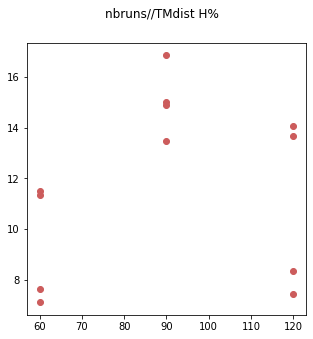

In [9]:
plt.figure(figsize=(5, 5))
plt.suptitle("nbruns//TMdist H%")
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            plt.scatter((60), np.mean([i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock']))]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 90:
            plt.scatter((90), np.mean([i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock']))]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 120:
            plt.scatter((120),np.mean([i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock']))]), color = rat_markers[animal][0])


/home/david/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/.local/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


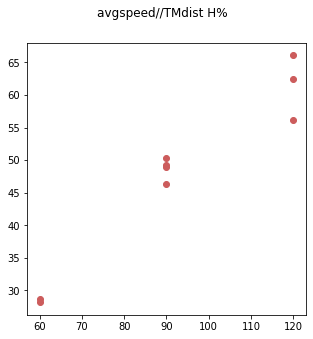

In [10]:
plt.figure(figsize=(5, 5))
plt.suptitle("avgspeed//TMdist H%")
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            plt.scatter((60), np.mean( [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 90:
            plt.scatter((90), np.mean( [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 120:
            plt.scatter((120),np.mean( [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])]), color = rat_markers[animal][0])




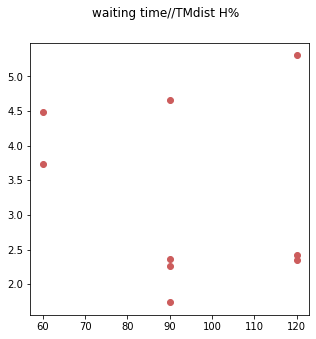

In [11]:
plt.figure(figsize=(5, 5))
plt.suptitle("waiting time//TMdist H%")
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            plt.scatter((60), np.mean([np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 90:
            plt.scatter((90), np.mean([np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 120:
            plt.scatter((120),np.mean([np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])]), color = rat_markers[animal][0])


In [12]:
###TODO###
#explain how data is processed
# Look at all the stuff in the bottom, possible cool stuff (explore weight effect and evolution /speed /peakspeed /number of runs, etc.)
# look at speed by computing it on X and Y axis, not only X
#compare between days
#add stats on figs
#average track per animal/group , dimension reduction
#analyse training data
#stats timeBins
#spread in scatter plot proportional to density*